# bSMOTE: Borderline-1

In [1]:
# import packages and read csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

features = pd.read_csv('DTI_with_group.csv')
# remove unnecessary columns and confounding variables
features = features.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
features = features.dropna()

features.head(5)

,AD_MCP,AD_PCT,AD_GCC,AD_BCC,AD_SCC,AD_FX,AD_CST_R,AD_CST_L,AD_ML_R,AD_ML_L,...,RD_FXST,RD_SLF,RD_SFO,RD_UNC,RD_TAP,RD_IC,RD_CC,RD_CR,RD_FULLWM,Research Group
0,0.001177,0.000974,0.001479,0.001474,0.001575,0.002257,0.001079,0.001081,0.001285,0.001287,...,0.000662,0.000577,0.000551,0.000600,0.001139,0.000491,0.000562,0.000638,0.000571,CN
2,0.001213,0.001075,0.001567,0.001585,0.001686,0.002492,0.001046,0.001056,0.001149,0.001126,...,0.000769,0.000694,0.000902,0.000717,0.001507,0.000626,0.000701,0.000851,0.000723,CN
3,0.001101,0.000965,0.001440,0.001433,0.001456,0.002379,0.000985,0.000990,0.001118,0.001113,...,0.000614,0.000546,0.000562,0.000553,0.000950,0.000448,0.000512,0.000587,0.000531,CN
4,0.001053,0.000904,0.001433,0.001470,0.001450,0.002421,0.000966,0.000977,0.001047,0.001041,...,0.000607,0.000535,0.000551,0.000530,0.000862,0.000437,0.000509,0.000573,0.000522,CN
5,0.001131,0.000974,0.001469,0.001498,0.001531,0.002291,0.000994,0.001017,0.001128,0.001105,...,0.000621,0.000559,0.000586,0.000558,0.000901,0.000458,0.000527,0.000605,0.000545,CN


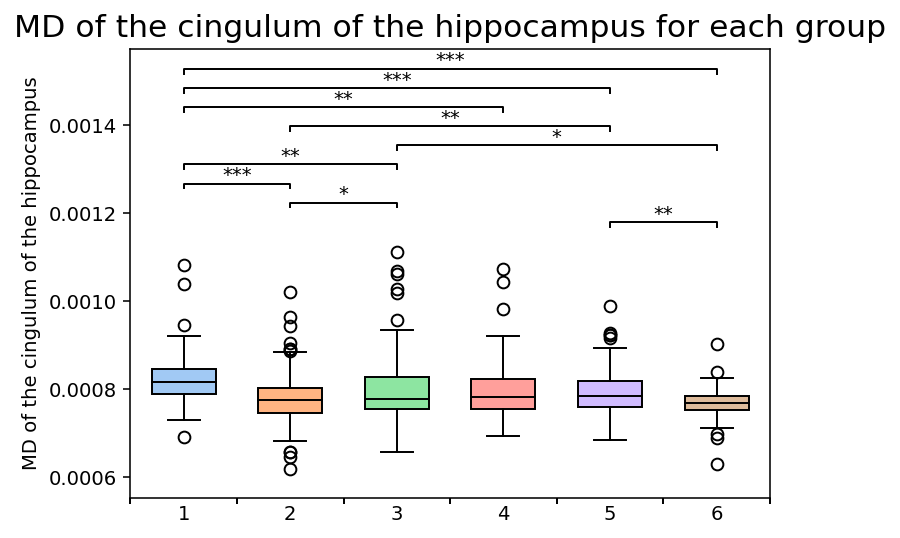

In [2]:
import seaborn as sns

col = 'MD_CGH_L'
data = [
    features[features['Research Group'] == 'AD'][col],
    features[features['Research Group'] == 'CN'][col],
    features[features['Research Group'] == 'EMCI'][col],
    features[features['Research Group'] == 'LMCI'][col],
    features[features['Research Group'] == 'MCI'][col],
    features[features['Research Group'] == 'SMC'][col],
]

# Make figures A6 in size
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
# Change figure quality
plt.rc('figure', dpi=141)

# Create a set of axes
ax = plt.axes()
# Create a boxplot on the axes
bp = ax.boxplot(data, widths=0.6, patch_artist=True)
# Graph title
ax.set_title('MD of the cingulum of the hippocampus for each group', fontsize=16)
# Label y-axis
ax.set_ylabel('MD of the cingulum of the hippocampus')
# Hide x-axis major ticks
ax.tick_params(axis='x', which='major', length=0)
# Show x-axis minor ticks
xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
ax.set_xticks(xticks, minor=True)
# Clean up the appearance
ax.tick_params(axis='x', which='minor', length=3, width=1)

# Change the colour of the boxes to Seaborn's 'pastel' palette
colors = sns.color_palette('pastel')
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Colour of the median lines
plt.setp(bp['medians'], color='k')

from scipy import stats

# Check for statistical significance
significant_combinations = []
# Check from the outside pairs of boxes inwards
ls = list(range(1, len(data) + 1))
combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
for c in combinations:
    data1 = data[c[0] - 1]
    data2 = data[c[1] - 1]
    # Significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    if p < 0.05:
        significant_combinations.append([c, p])

# Get info about y-axis
bottom, top = ax.get_ylim()
yrange = top - bottom

# Significance bars
for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (yrange * 0.08 * level) + top
    bar_tips = bar_height - (yrange * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (yrange * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', c='k')

# Adjust y-axis
bottom, top = ax.get_ylim()
yrange = top - bottom
ax.set_ylim(bottom - 0.02 * yrange, top)


plt.show()

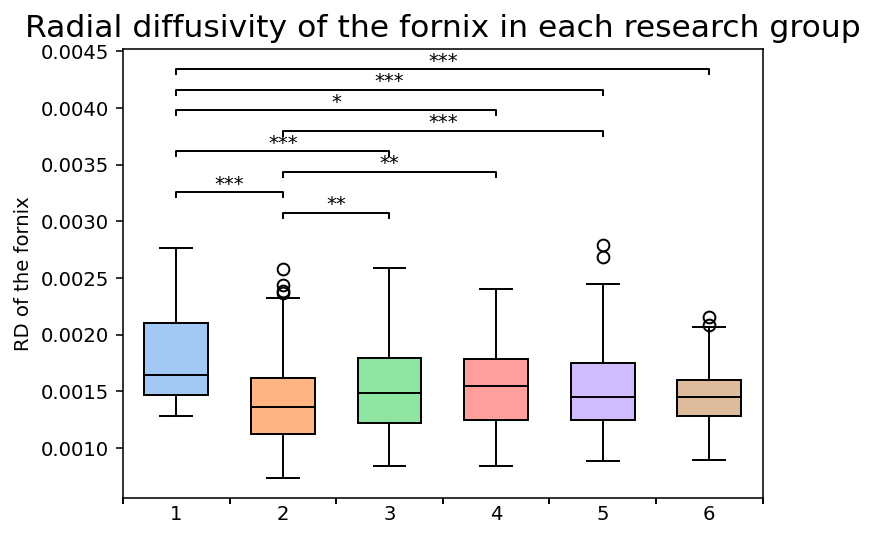

In [3]:
import seaborn as sns

col = 'RD_FX'
data = [
    features[features['Research Group'] == 'AD'][col],
    features[features['Research Group'] == 'CN'][col],
    features[features['Research Group'] == 'EMCI'][col],
    features[features['Research Group'] == 'LMCI'][col],
    features[features['Research Group'] == 'MCI'][col],
    features[features['Research Group'] == 'SMC'][col],
]

# Make figures A6 in size
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
# Change figure quality
plt.rc('figure', dpi=141)

# Create a set of axes
ax = plt.axes()
# Create a boxplot on the axes
bp = ax.boxplot(data, widths=0.6, patch_artist=True)
# Graph title
ax.set_title('Radial diffusivity of the fornix in each research group', fontsize=16)
# Label y-axis
ax.set_ylabel('RD of the fornix')
# Hide x-axis major ticks
ax.tick_params(axis='x', which='major', length=0)
# Show x-axis minor ticks
xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
ax.set_xticks(xticks, minor=True)
# Clean up the appearance
ax.tick_params(axis='x', which='minor', length=3, width=1)

# Change the colour of the boxes to Seaborn's 'pastel' palette
colors = sns.color_palette('pastel')
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Colour of the median lines
plt.setp(bp['medians'], color='k')

# Check for statistical significance
significant_combinations = []
# Check from the outside pairs of boxes inwards
ls = list(range(1, len(data) + 1))
combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
for c in combinations:
    data1 = data[c[0] - 1]
    data2 = data[c[1] - 1]
    # Significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    if p < 0.05:
        significant_combinations.append([c, p])

# Get info about y-axis
bottom, top = ax.get_ylim()
yrange = top - bottom

# Significance bars
for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (yrange * 0.08 * level) + top
    bar_tips = bar_height - (yrange * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (yrange * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', c='k')

plt.show()

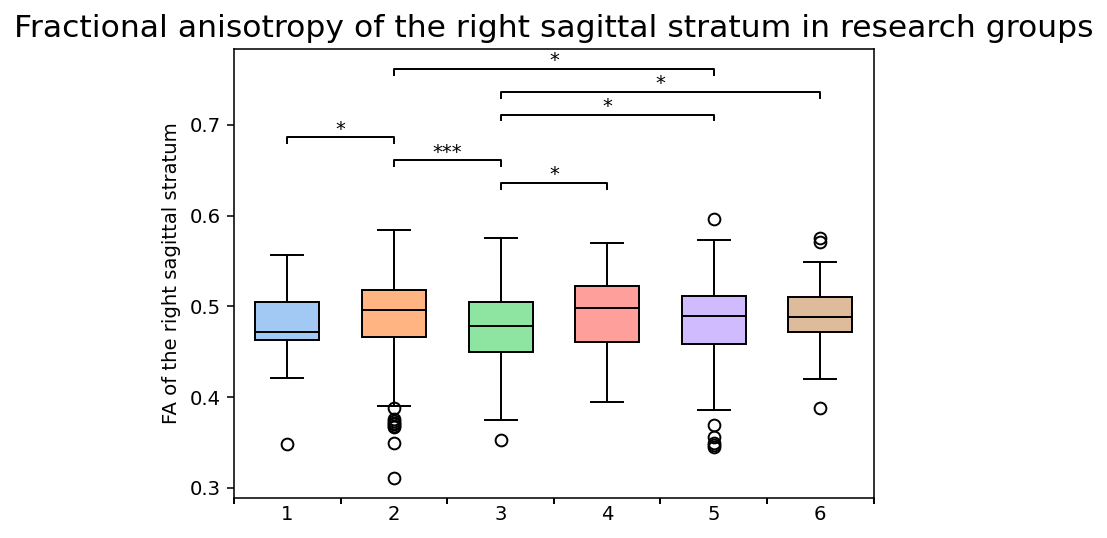

In [4]:
import seaborn as sns

col = 'FA_SS_R'
data = [
    features[features['Research Group'] == 'AD'][col],
    features[features['Research Group'] == 'CN'][col],
    features[features['Research Group'] == 'EMCI'][col],
    features[features['Research Group'] == 'LMCI'][col],
    features[features['Research Group'] == 'MCI'][col],
    features[features['Research Group'] == 'SMC'][col],
]

# Make figures A6 in size
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
# Change figure quality
plt.rc('figure', dpi=141)

# Create a set of axes
ax = plt.axes()
# Create a boxplot on the axes
bp = ax.boxplot(data, widths=0.6, patch_artist=True)
# Graph title
ax.set_title('Fractional anisotropy of the right sagittal stratum in research groups', fontsize=16)
# Label y-axis
ax.set_ylabel('FA of the right sagittal stratum')
# Hide x-axis major ticks
ax.tick_params(axis='x', which='major', length=0)
# Show x-axis minor ticks
xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
ax.set_xticks(xticks, minor=True)
# Clean up the appearance
ax.tick_params(axis='x', which='minor', length=3, width=1)

# Change the colour of the boxes to Seaborn's 'pastel' palette
colors = sns.color_palette('pastel')
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Colour of the median lines
plt.setp(bp['medians'], color='k')

# Check for statistical significance
significant_combinations = []
# Check from the outside pairs of boxes inwards
ls = list(range(1, len(data) + 1))
combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
for c in combinations:
    data1 = data[c[0] - 1]
    data2 = data[c[1] - 1]
    # Significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    if p < 0.05:
        significant_combinations.append([c, p])

# Get info about y-axis
bottom, top = ax.get_ylim()
yrange = top - bottom

# Significance bars
for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (yrange * 0.08 * level) + top
    bar_tips = bar_height - (yrange * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (yrange * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', c='k')

plt.show()

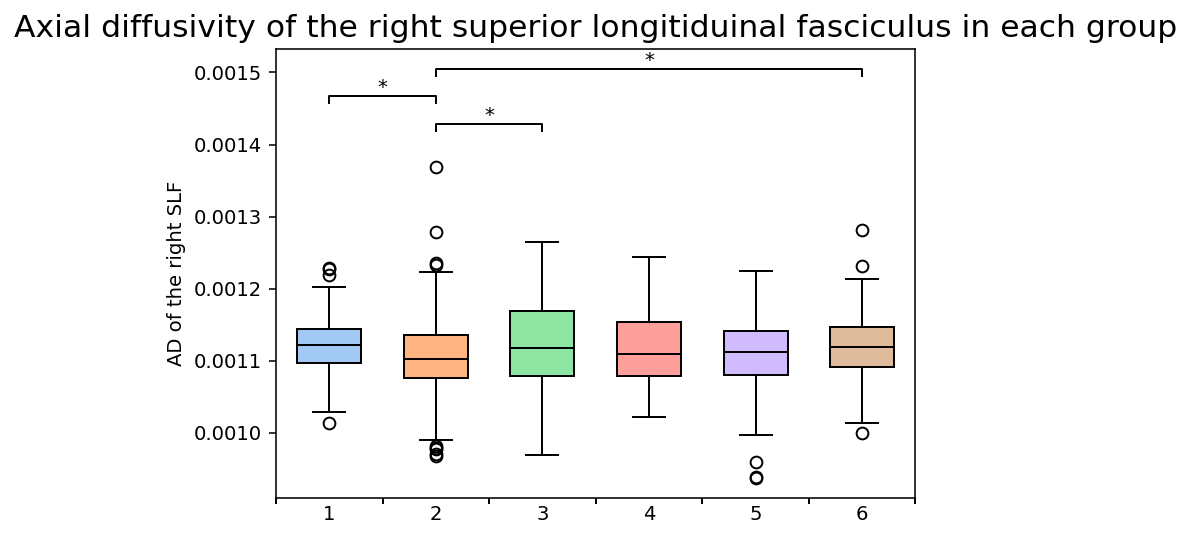

In [5]:
import seaborn as sns

col = 'AD_SLF_R'
data = [
    features[features['Research Group'] == 'AD'][col],
    features[features['Research Group'] == 'CN'][col],
    features[features['Research Group'] == 'EMCI'][col],
    features[features['Research Group'] == 'LMCI'][col],
    features[features['Research Group'] == 'MCI'][col],
    features[features['Research Group'] == 'SMC'][col],
]

# Make figures A6 in size
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
# Change figure quality
plt.rc('figure', dpi=141)

# Create a set of axes
ax = plt.axes()
# Create a boxplot on the axes
bp = ax.boxplot(data, widths=0.6, patch_artist=True)
# Graph title
ax.set_title('Axial diffusivity of the right superior longitiduinal fasciculus in each group', fontsize=16)
# Label y-axis
ax.set_ylabel('AD of the right SLF')
# Hide x-axis major ticks
ax.tick_params(axis='x', which='major', length=0)
# Show x-axis minor ticks
xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
ax.set_xticks(xticks, minor=True)
# Clean up the appearance
ax.tick_params(axis='x', which='minor', length=3, width=1)

# Change the colour of the boxes to Seaborn's 'pastel' palette
colors = sns.color_palette('pastel')
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Colour of the median lines
plt.setp(bp['medians'], color='k')

# Check for statistical significance
significant_combinations = []
# Check from the outside pairs of boxes inwards
ls = list(range(1, len(data) + 1))
combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
for c in combinations:
    data1 = data[c[0] - 1]
    data2 = data[c[1] - 1]
    # Significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    if p < 0.05:
        significant_combinations.append([c, p])

# Get info about y-axis
bottom, top = ax.get_ylim()
yrange = top - bottom

# Significance bars
for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (yrange * 0.08 * level) + top
    bar_tips = bar_height - (yrange * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (yrange * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', c='k')

plt.show()

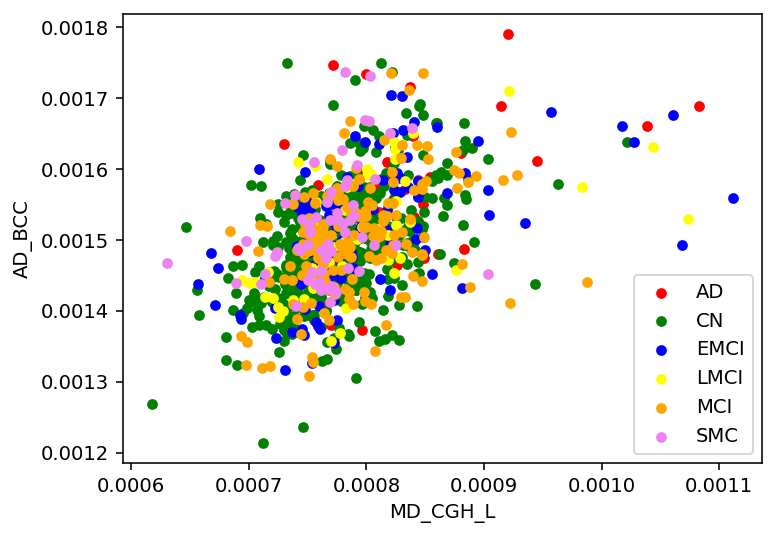

In [6]:
fig, ax = plt.subplots()
colors = {'AD':'red', 'CN':'green', 'EMCI':'blue', 'LMCI':'yellow', 'MCI':'orange', 'SMC':'violet'}
grouped = features.groupby('Research Group')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='MD_CGH_L', y='AD_BCC', label=key, color=colors[key])
plt.show()

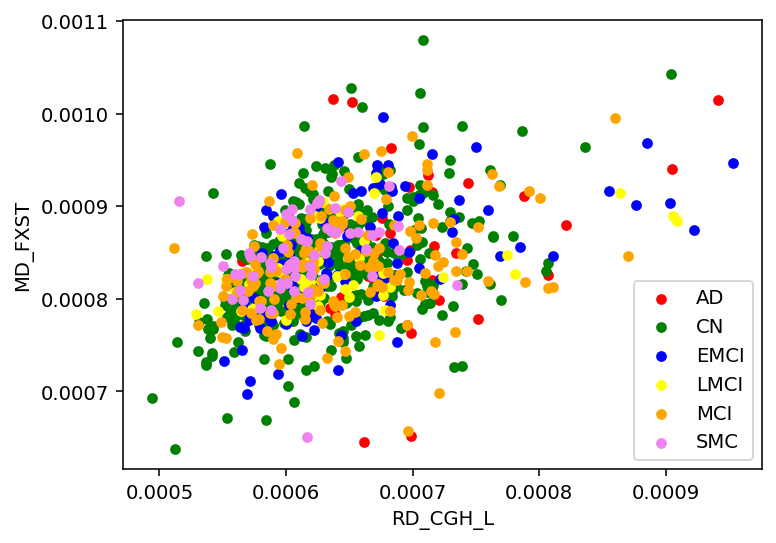

In [7]:
fig, ax = plt.subplots()
colors = {'AD':'red', 'CN':'green', 'EMCI':'blue', 'LMCI':'yellow', 'MCI':'orange', 'SMC':'violet'}
grouped = features.groupby('Research Group')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='RD_CGH_L', y='MD_FXST', label=key, color=colors[key])
plt.show()

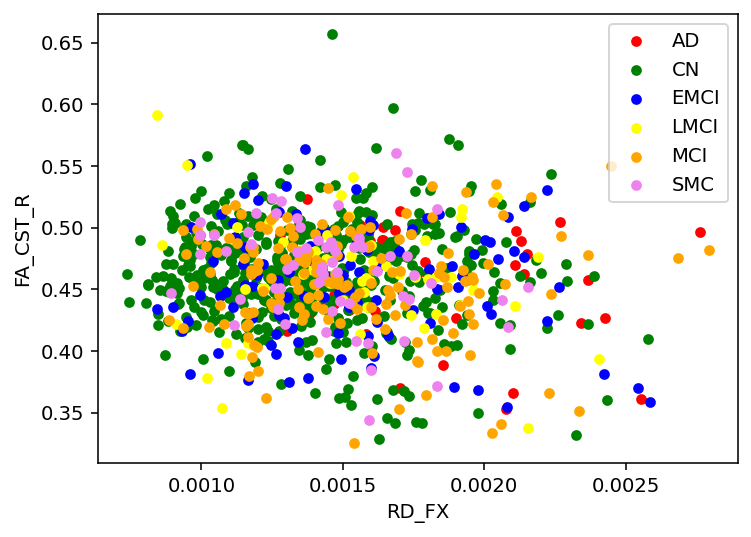

In [8]:
fig, ax = plt.subplots()
colors = {'AD':'red', 'CN':'green', 'EMCI':'blue', 'LMCI':'yellow', 'MCI':'orange', 'SMC':'violet'}
grouped = features.groupby('Research Group')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='RD_FX', y='FA_CST_R', label=key, color=colors[key])
plt.show()

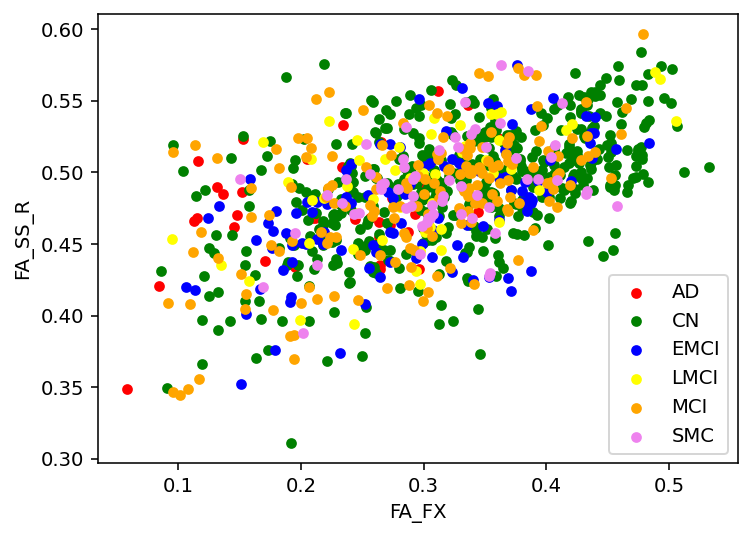

In [9]:
fig, ax = plt.subplots()
colors = {'AD':'red', 'CN':'green', 'EMCI':'blue', 'LMCI':'yellow', 'MCI':'orange', 'SMC':'violet'}
grouped = features.groupby('Research Group')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='FA_FX', y='FA_SS_R', label=key, color=colors[key])
plt.show()

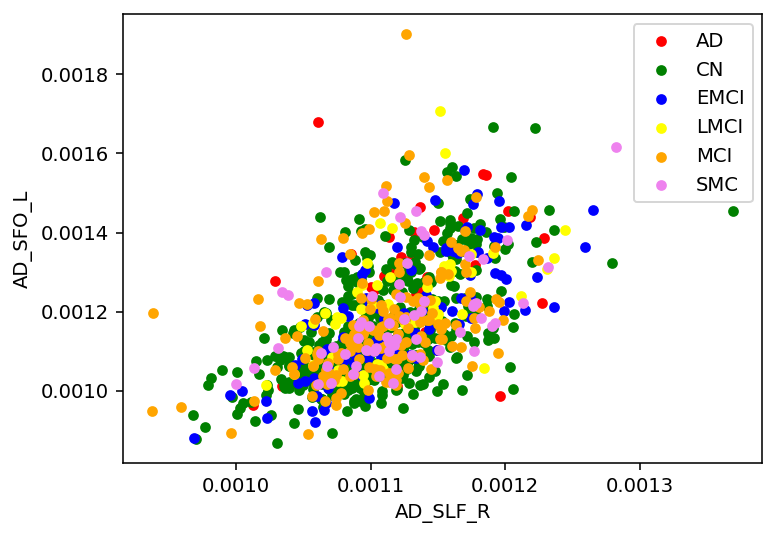

In [10]:
fig, ax = plt.subplots()
colors = {'AD':'red', 'CN':'green', 'EMCI':'blue', 'LMCI':'yellow', 'MCI':'orange', 'SMC':'violet'}
grouped = features.groupby('Research Group')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='AD_SLF_R', y='AD_SFO_L', label=key, color=colors[key])
plt.show()

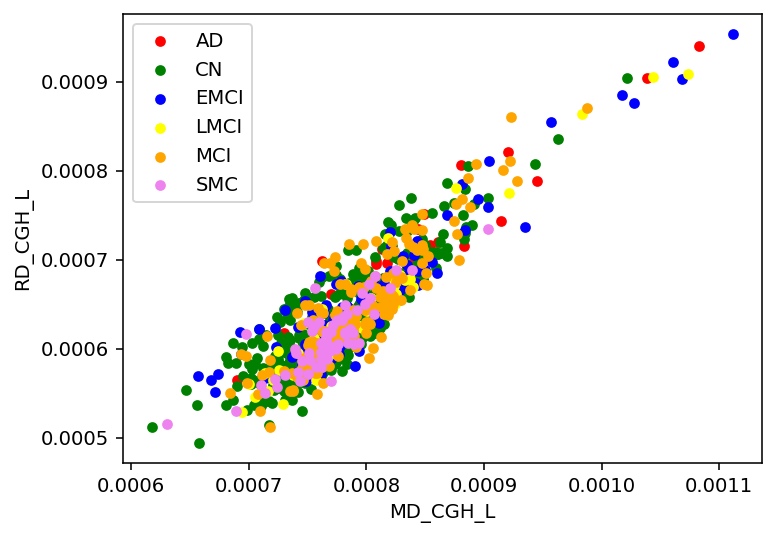

In [11]:
fig, ax = plt.subplots()
colors = {'AD':'red', 'CN':'green', 'EMCI':'blue', 'LMCI':'yellow', 'MCI':'orange', 'SMC':'violet'}
grouped = features.groupby('Research Group')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='MD_CGH_L', y='RD_CGH_L', label=key, color=colors[key])
plt.show()

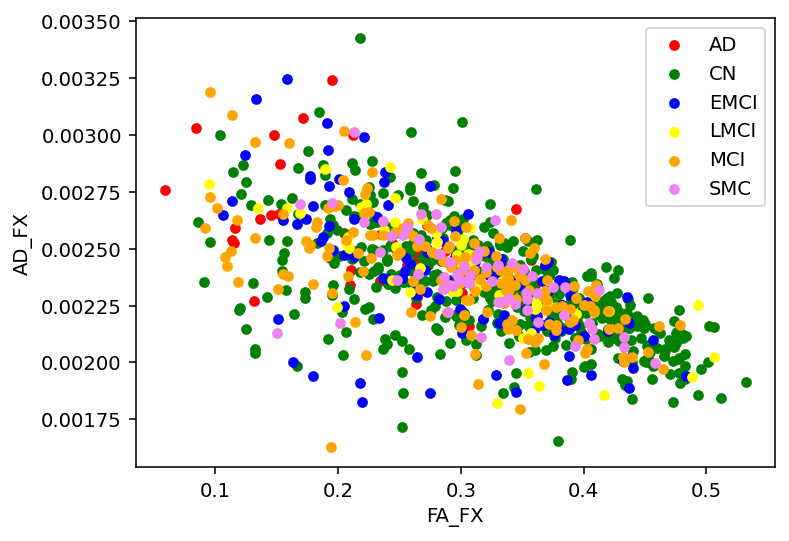

In [12]:
fig, ax = plt.subplots()
colors = {'AD':'red', 'CN':'green', 'EMCI':'blue', 'LMCI':'yellow', 'MCI':'orange', 'SMC':'violet'}
grouped = features.groupby('Research Group')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='FA_FX', y='AD_FX', label=key, color=colors[key])
plt.show()

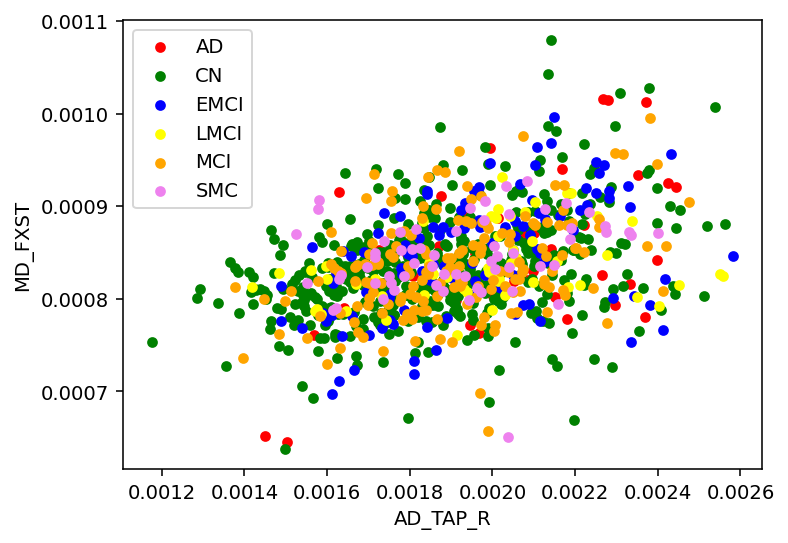

In [13]:
fig, ax = plt.subplots()
colors = {'AD':'red', 'CN':'green', 'EMCI':'blue', 'LMCI':'yellow', 'MCI':'orange', 'SMC':'violet'}
grouped = features.groupby('Research Group')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='AD_TAP_R', y='MD_FXST', label=key, color=colors[key])
plt.show()

In [14]:
from imblearn.over_sampling import BorderlineSMOTE as bSMOTE
X = features.iloc[:, features.columns != 'Research Group'].values
y = features.iloc[:, -1].values
X_resampled, y_resampled = bSMOTE(kind='borderline-1').fit_resample(X, y)

In [15]:
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 14)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model with decision trees
clf = RandomForestClassifier(n_estimators = 9000, random_state = 88, oob_score = True)

# Train the model on training data
clf.fit(X_train, y_train);

In [17]:
pred = clf.predict(X_test)
clf.score(X_train, y_train)

1.0

In [18]:
clf.score(X_test, y_test)

0.9138461538461539

In [19]:
print(confusion_matrix(y_test, pred))

[[161   1   0   0   2   0]
 [  1 135  11   3  21   7]
 [  1   3 133   0   4   1]
 [  1   1   0 159   0   0]
 [  0  14   4   0 152   3]
 [  2   4   0   0   0 151]]


In [20]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.97      0.98      0.98       164
          CN       0.85      0.76      0.80       178
        EMCI       0.90      0.94      0.92       142
        LMCI       0.98      0.99      0.98       161
         MCI       0.85      0.88      0.86       173
         SMC       0.93      0.96      0.95       157

    accuracy                           0.91       975
   macro avg       0.91      0.92      0.92       975
weighted avg       0.91      0.91      0.91       975



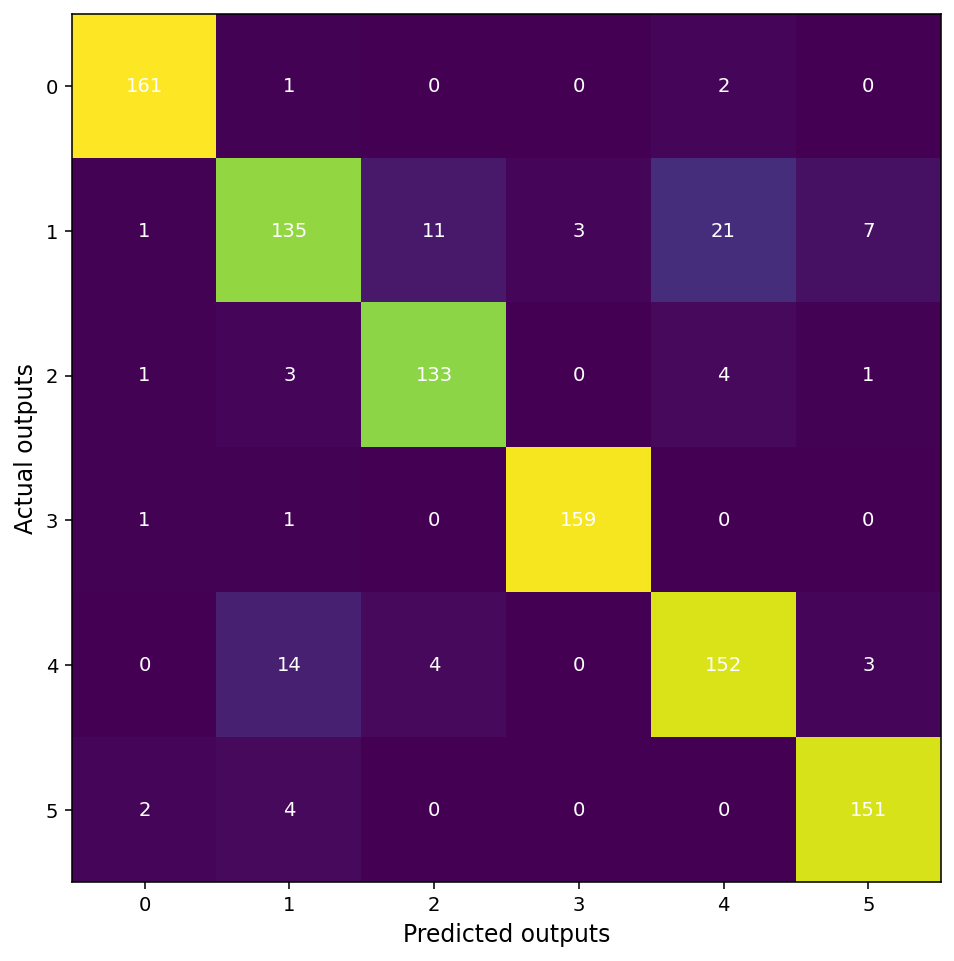

In [21]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(6))
ax.yaxis.set(ticks=range(6))
for i in range(6):
    for j in range(6):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

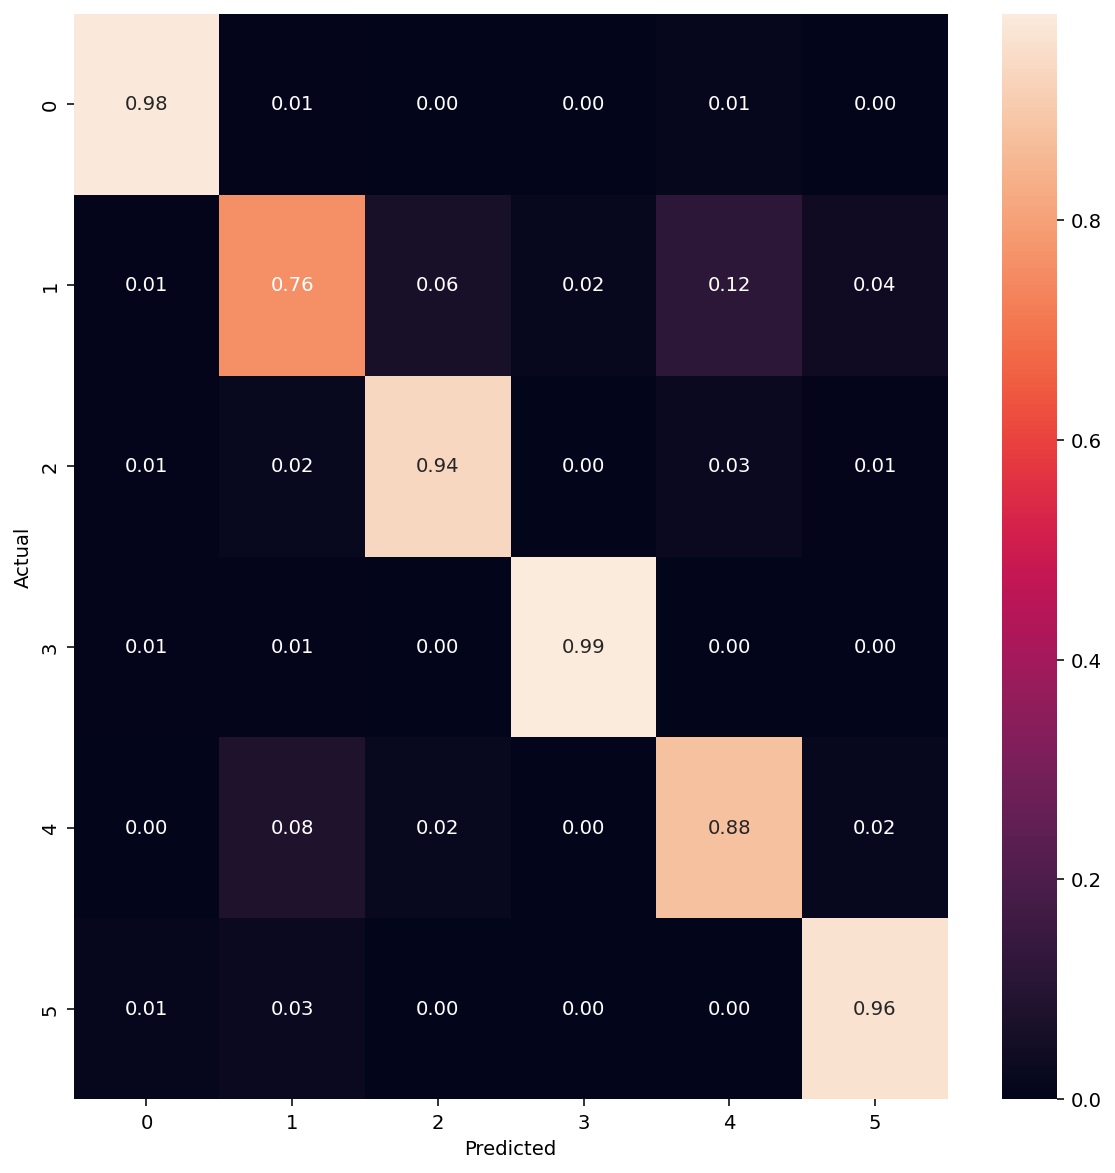

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### Combined MCI groups

In [23]:
features = pd.read_csv('DTI_with_group_comb.csv')
# remove unnecessary columns and confounding variables
features = features.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
features = features.dropna()

features.head(5)

,AD_MCP,AD_PCT,AD_GCC,AD_BCC,AD_SCC,AD_FX,AD_CST_R,AD_CST_L,AD_ML_R,AD_ML_L,...,RD_FXST,RD_SLF,RD_SFO,RD_UNC,RD_TAP,RD_IC,RD_CC,RD_CR,RD_FULLWM,Research Group
0,0.001177,0.000974,0.001479,0.001474,0.001575,0.002257,0.001079,0.001081,0.001285,0.001287,...,0.000662,0.000577,0.000551,0.000600,0.001139,0.000491,0.000562,0.000638,0.000571,CN
2,0.001213,0.001075,0.001567,0.001585,0.001686,0.002492,0.001046,0.001056,0.001149,0.001126,...,0.000769,0.000694,0.000902,0.000717,0.001507,0.000626,0.000701,0.000851,0.000723,CN
3,0.001101,0.000965,0.001440,0.001433,0.001456,0.002379,0.000985,0.000990,0.001118,0.001113,...,0.000614,0.000546,0.000562,0.000553,0.000950,0.000448,0.000512,0.000587,0.000531,CN
4,0.001053,0.000904,0.001433,0.001470,0.001450,0.002421,0.000966,0.000977,0.001047,0.001041,...,0.000607,0.000535,0.000551,0.000530,0.000862,0.000437,0.000509,0.000573,0.000522,CN
5,0.001131,0.000974,0.001469,0.001498,0.001531,0.002291,0.000994,0.001017,0.001128,0.001105,...,0.000621,0.000559,0.000586,0.000558,0.000901,0.000458,0.000527,0.000605,0.000545,CN


In [24]:
from imblearn.over_sampling import BorderlineSMOTE as bSMOTE
X = features.iloc[:, features.columns != 'Research Group'].values
y = features.iloc[:, -1].values
X_resampled, y_resampled = bSMOTE(kind='borderline-1').fit_resample(X, y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 14)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
# instantiate model with decision trees
clf = RandomForestClassifier(n_estimators = 9000, random_state = 88, oob_score = True)

# Train the model on training data
clf.fit(X_train, y_train);

In [27]:
pred = clf.predict(X_test)
clf.score(X_train, y_train)

1.0

In [28]:
clf.score(X_test, y_test)

0.8306010928961749

In [29]:
print(confusion_matrix(y_test, pred))

[[172   7   4]
 [  2 137  28]
 [  4  48 147]]


In [30]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.97      0.94      0.95       183
          CN       0.71      0.82      0.76       167
         MCI       0.82      0.74      0.78       199

    accuracy                           0.83       549
   macro avg       0.83      0.83      0.83       549
weighted avg       0.84      0.83      0.83       549



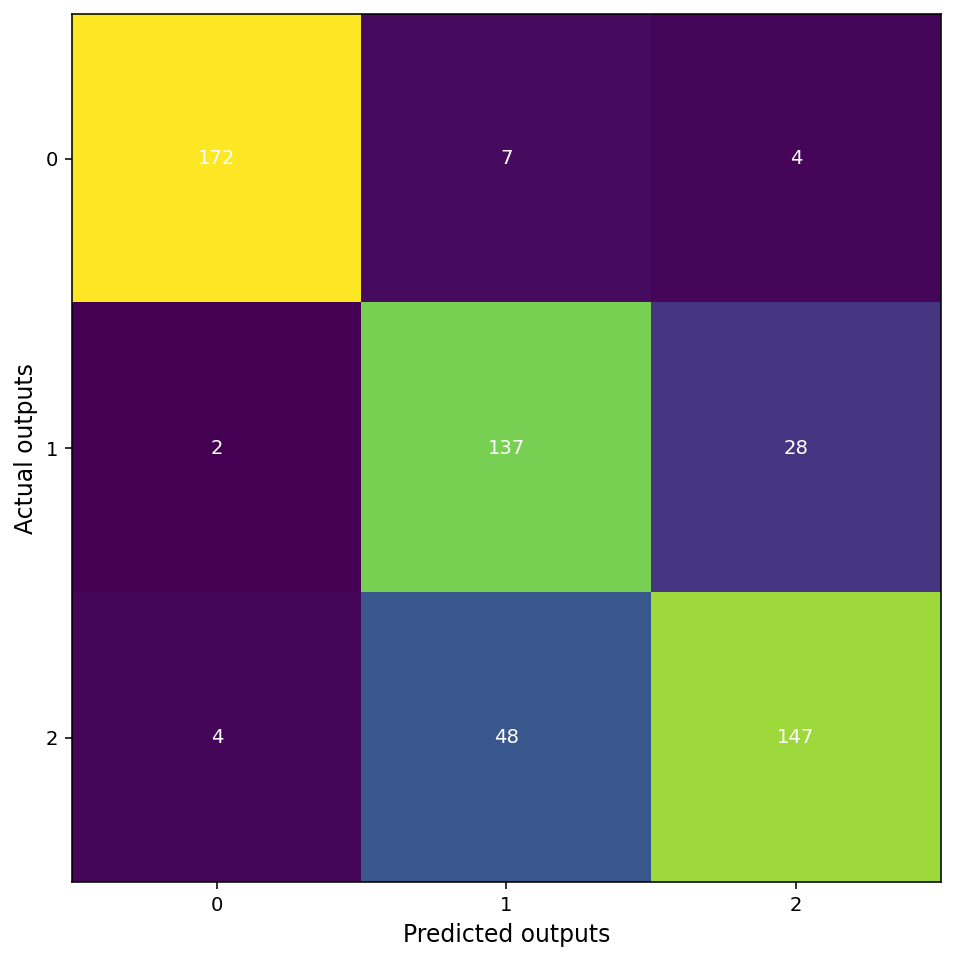

In [31]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(3))
ax.yaxis.set(ticks=range(3))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

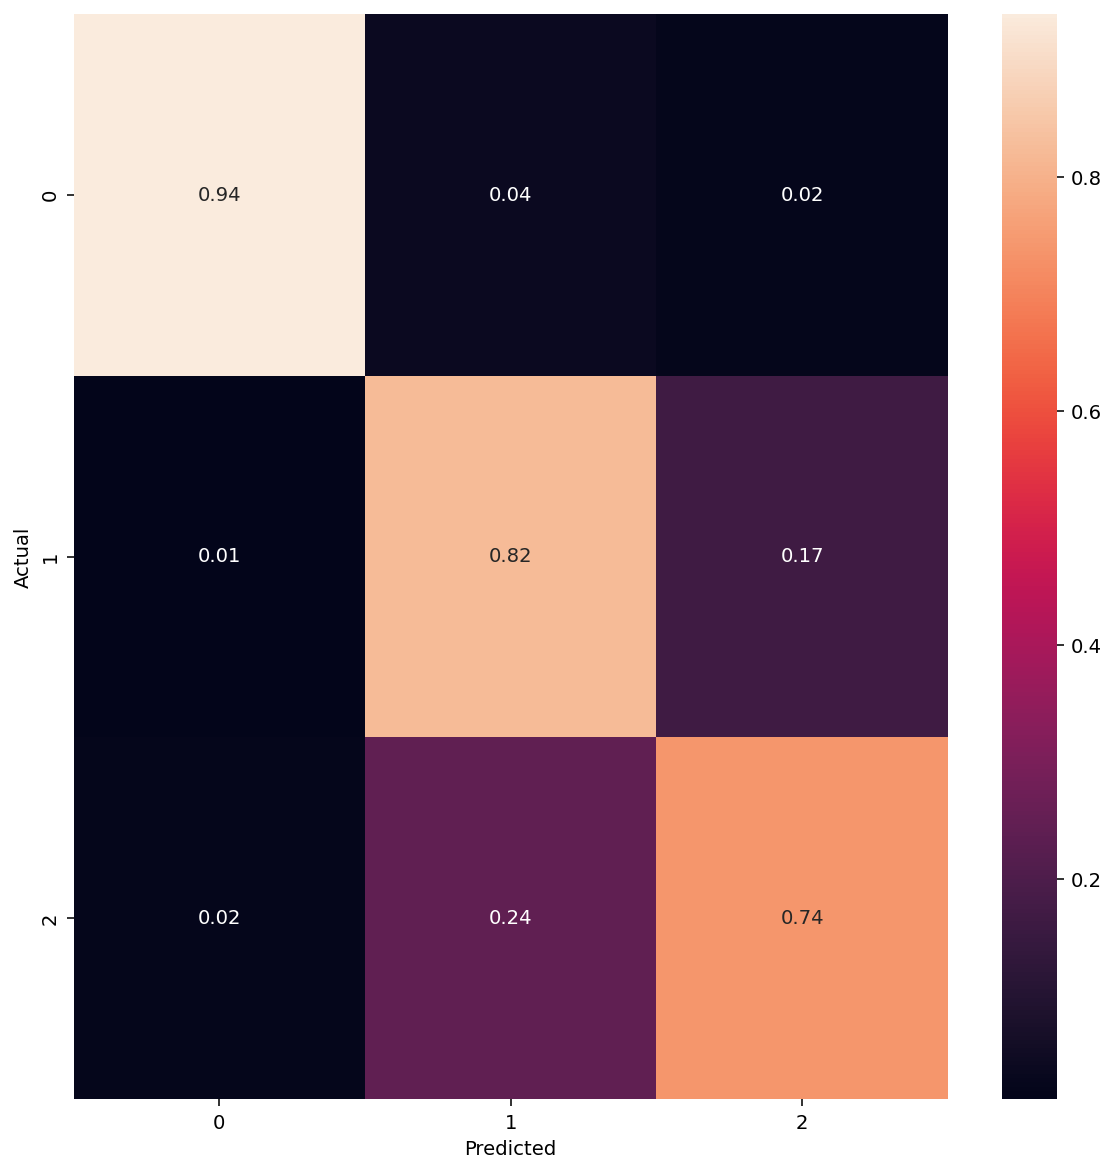

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# bSMOTE with SVM

In [33]:
from imblearn.over_sampling import SVMSMOTE
features = pd.read_csv('DTI_with_group.csv')
# remove unnecessary columns and confounding variables
features = features.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
features = features.dropna()

In [34]:
X = features.iloc[:, features.columns != 'Research Group'].values
y = features.iloc[:, -1].values
X_resampled, y_resampled = SVMSMOTE().fit_resample(X, y)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 14)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
# instantiate model with decision trees
clf = RandomForestClassifier(n_estimators = 9000, random_state = 93, oob_score = True)

# Train the model on training data
clf.fit(X_train, y_train);

In [37]:
pred = clf.predict(X_test)
clf.score(X_train, y_train)

1.0

In [38]:
clf.score(X_test, y_test)

0.8676470588235294

In [39]:
print(confusion_matrix(y_test, pred))

[[ 61   5   0   1   1   0]
 [  1 135  11   5  10   2]
 [  1   8 105   0   0   0]
 [  0   1   1  91   0   0]
 [  0  35   0   3 132   0]
 [  0   4   1   0   0  66]]


In [40]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.97      0.90      0.93        68
          CN       0.72      0.82      0.77       164
        EMCI       0.89      0.92      0.91       114
        LMCI       0.91      0.98      0.94        93
         MCI       0.92      0.78      0.84       170
         SMC       0.97      0.93      0.95        71

    accuracy                           0.87       680
   macro avg       0.90      0.89      0.89       680
weighted avg       0.88      0.87      0.87       680



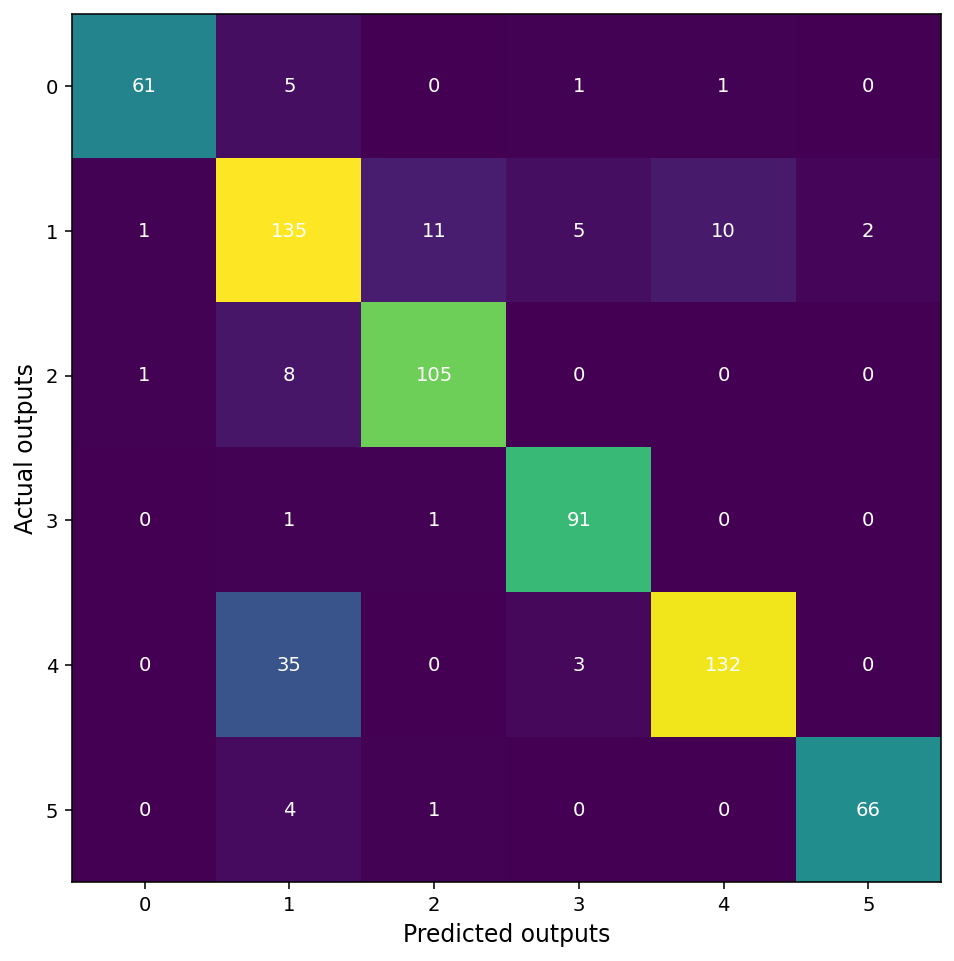

In [41]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(6))
ax.yaxis.set(ticks=range(6))
for i in range(6):
    for j in range(6):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

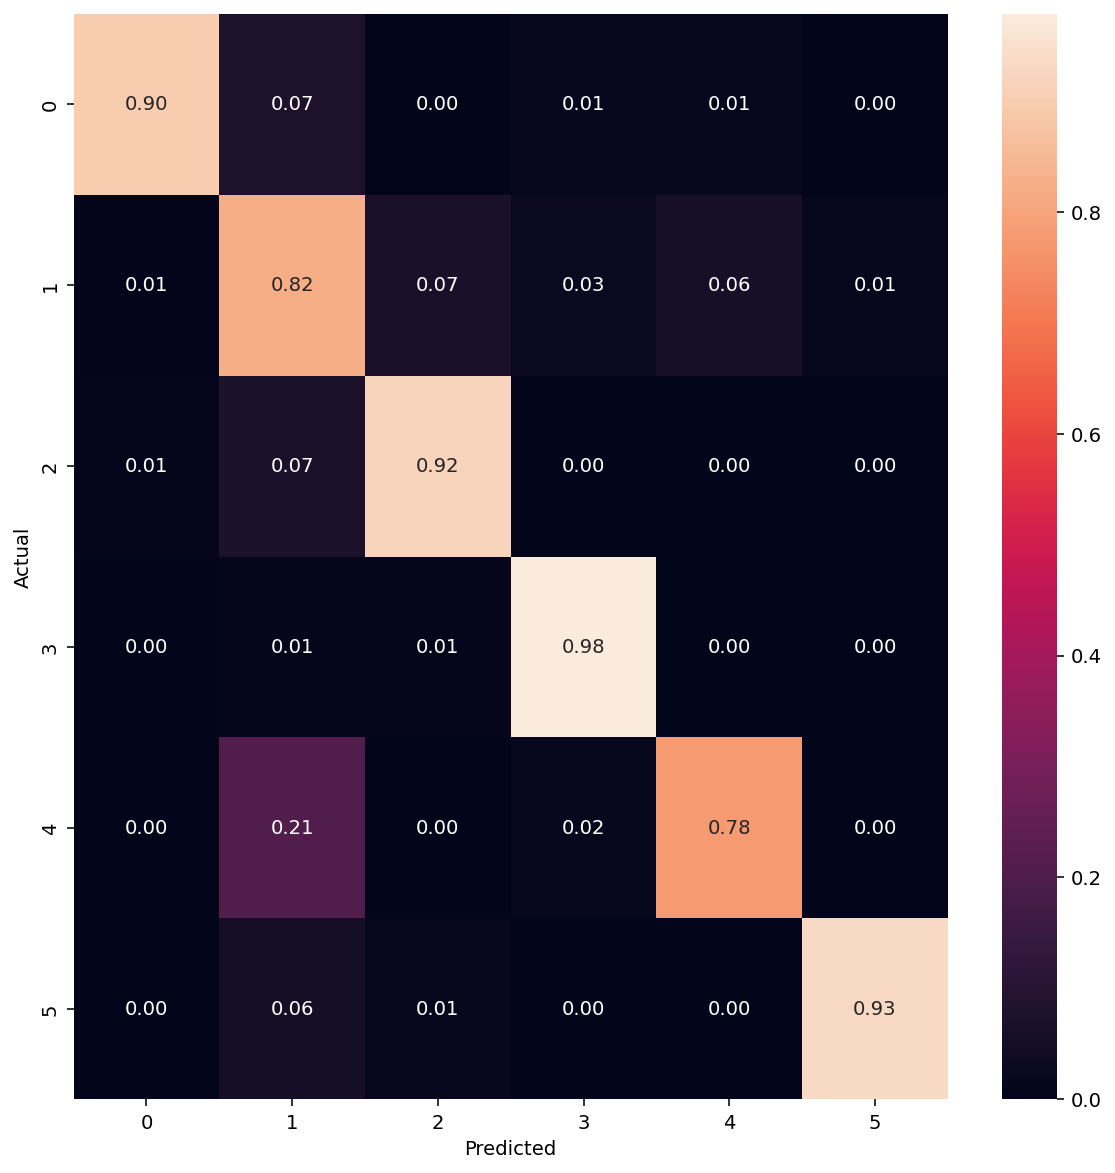

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### Combined MCI groups

In [43]:
features = pd.read_csv('DTI_with_group_comb.csv')
# remove unnecessary columns and confounding variables
features = features.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
features = features.dropna()

In [44]:
X = features.iloc[:, features.columns != 'Research Group'].values
y = features.iloc[:, -1].values
X_resampled, y_resampled = SVMSMOTE().fit_resample(X, y)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 14)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
# instantiate model with decision trees
clf = RandomForestClassifier(n_estimators = 9000, random_state = 93, oob_score = True)

# Train the model on training data
clf.fit(X_train, y_train);

In [47]:
pred = clf.predict(X_test)
clf.score(X_train, y_train)

1.0

In [48]:
clf.score(X_test, y_test)

0.7874186550976139

In [49]:
print(confusion_matrix(y_test, pred))

[[ 82   7   3]
 [  3 141  31]
 [  4  50 140]]


In [50]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.92      0.89      0.91        92
          CN       0.71      0.81      0.76       175
         MCI       0.80      0.72      0.76       194

    accuracy                           0.79       461
   macro avg       0.81      0.81      0.81       461
weighted avg       0.79      0.79      0.79       461



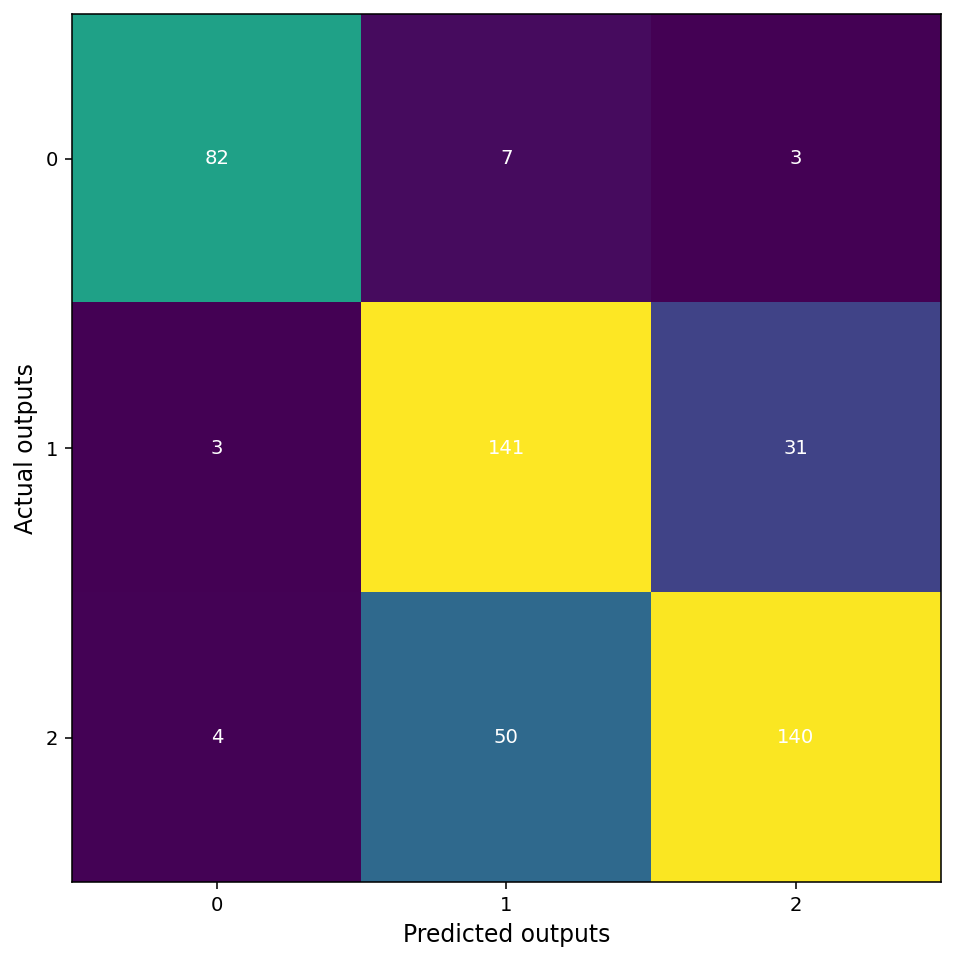

In [51]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(3))
ax.yaxis.set(ticks=range(3))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

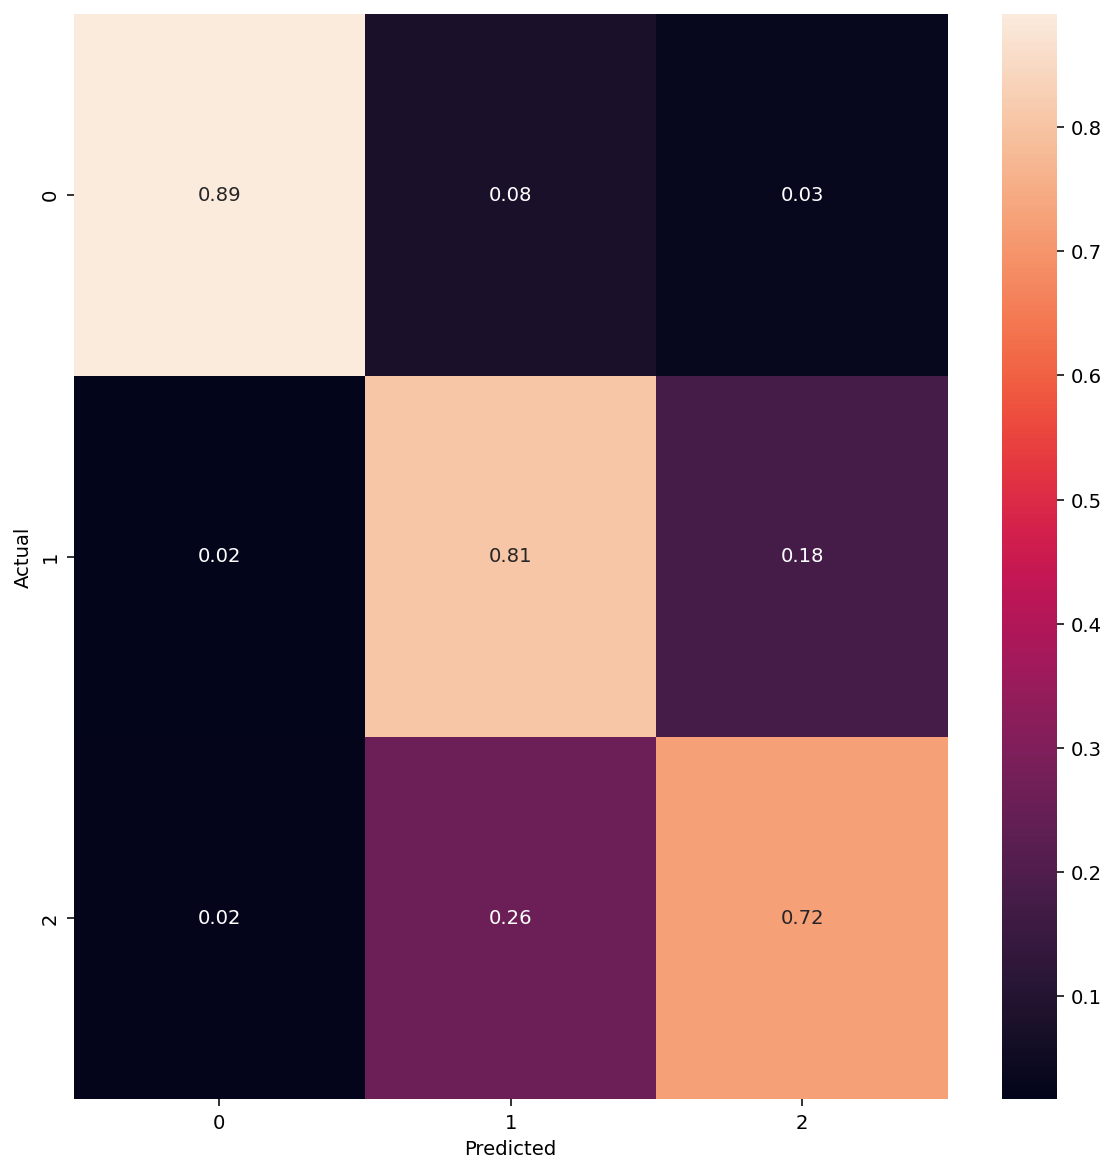

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# SMOTE + ENN

In [53]:
features = pd.read_csv('DTI_with_group.csv')
# remove unnecessary columns and confounding variables
features = features.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
features = features.dropna()

In [54]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=4)
X = features.iloc[:, features.columns != 'Research Group'].values
y = features.iloc[:, -1].values
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 18)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [56]:
# instantiate model with decision trees
clf = RandomForestClassifier(n_estimators = 9000, random_state = 111, oob_score = True)

# Train the model on training data
clf.fit(X_train, y_train);

In [57]:
pred = clf.predict(X_test)
clf.score(X_train, y_train)

1.0

In [58]:
clf.score(X_test, y_test)

0.9670886075949368

In [59]:
print(confusion_matrix(y_test, pred))

[[157   0   0   1   0   1]
 [  0   0   2   2   5   1]
 [  1   0 137   0   1   1]
 [  0   0   1 171   2   0]
 [  1   0   1   0 139   3]
 [  0   0   0   0   3 160]]


In [60]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.99      0.99      0.99       159
          CN       0.00      0.00      0.00        10
        EMCI       0.97      0.98      0.98       140
        LMCI       0.98      0.98      0.98       174
         MCI       0.93      0.97      0.95       144
         SMC       0.96      0.98      0.97       163

    accuracy                           0.97       790
   macro avg       0.81      0.82      0.81       790
weighted avg       0.96      0.97      0.96       790



/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

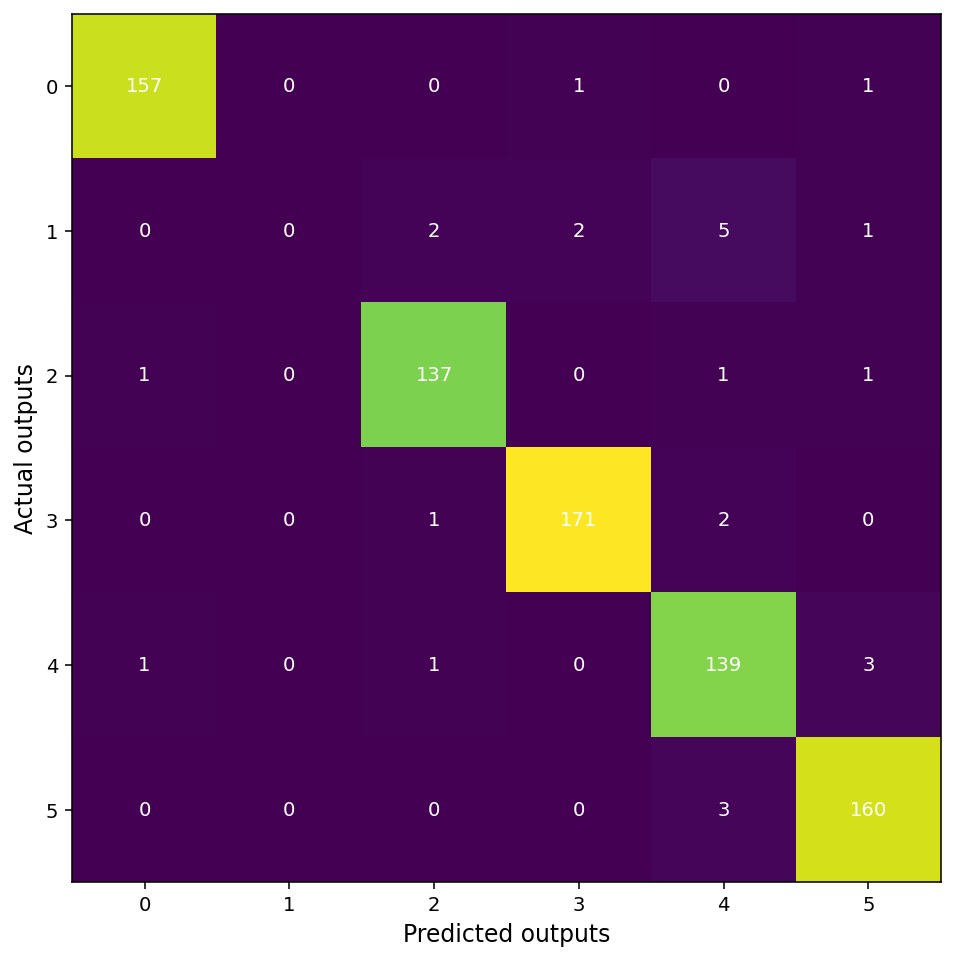

In [61]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(6))
ax.yaxis.set(ticks=range(6))
for i in range(6):
    for j in range(6):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

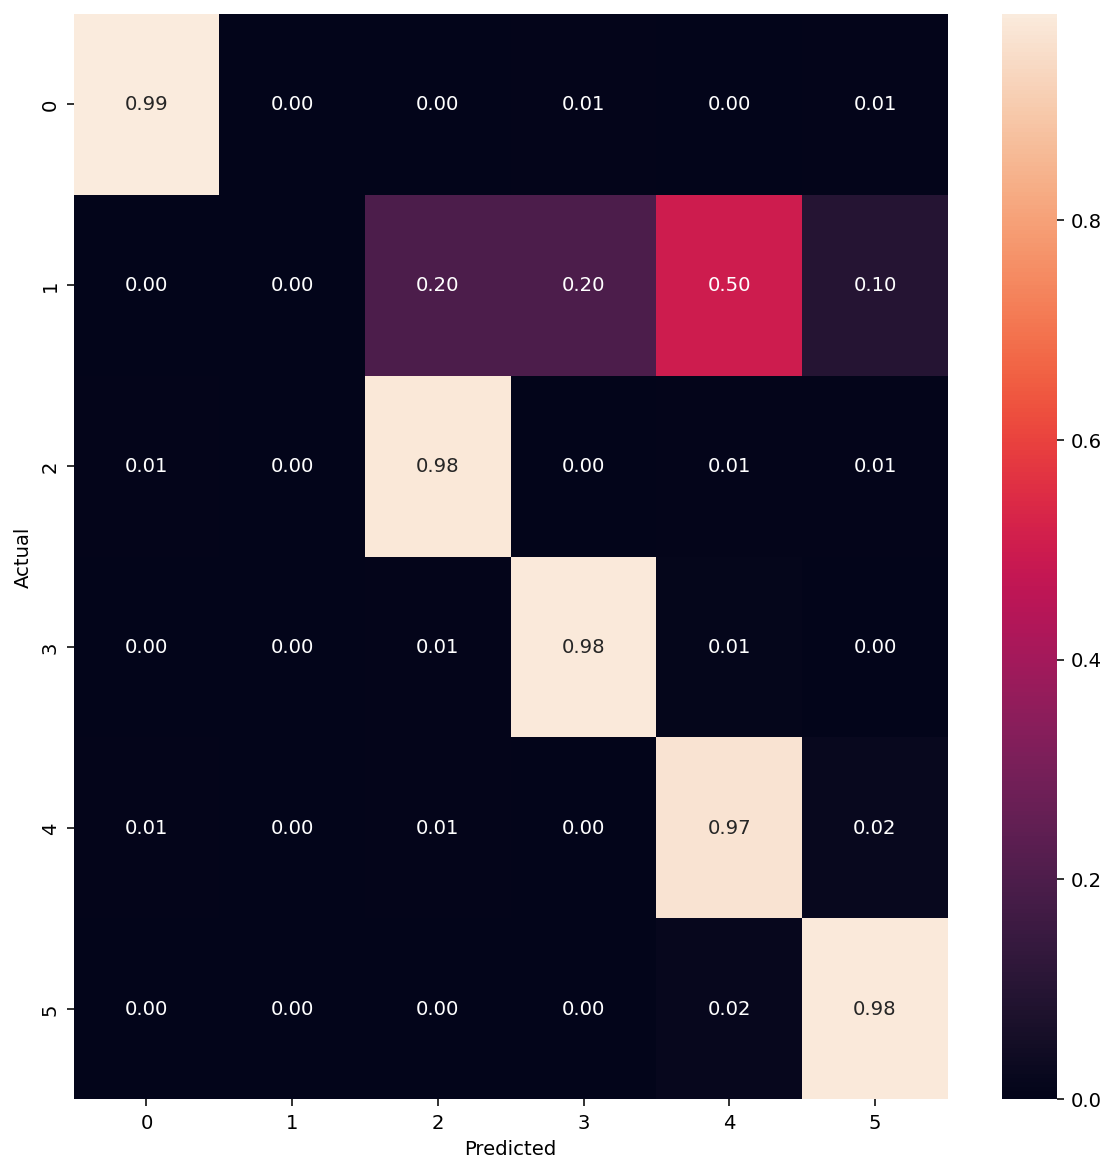

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### Combined MCI groups

In [63]:
features = pd.read_csv('DTI_with_group_comb.csv')
# remove unnecessary columns and confounding variables
features = features.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
features = features.dropna()

In [64]:
smote_enn = SMOTEENN(random_state=4)
X = features.iloc[:, features.columns != 'Research Group'].values
y = features.iloc[:, -1].values
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.33, random_state = 18)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [66]:
# instantiate model with decision trees
clf = RandomForestClassifier(n_estimators = 9000, random_state = 111, oob_score = True)

# Train the model on training data
clf.fit(X_train, y_train);

In [67]:
pred = clf.predict(X_test)
clf.score(X_train, y_train)

1.0

In [68]:
clf.score(X_test, y_test)

0.8885542168674698

In [69]:
print(confusion_matrix(y_test, pred))

[[183   0   0]
 [  0  13  30]
 [  6   1  99]]


In [70]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.97      1.00      0.98       183
          CN       0.93      0.30      0.46        43
         MCI       0.77      0.93      0.84       106

    accuracy                           0.89       332
   macro avg       0.89      0.75      0.76       332
weighted avg       0.90      0.89      0.87       332



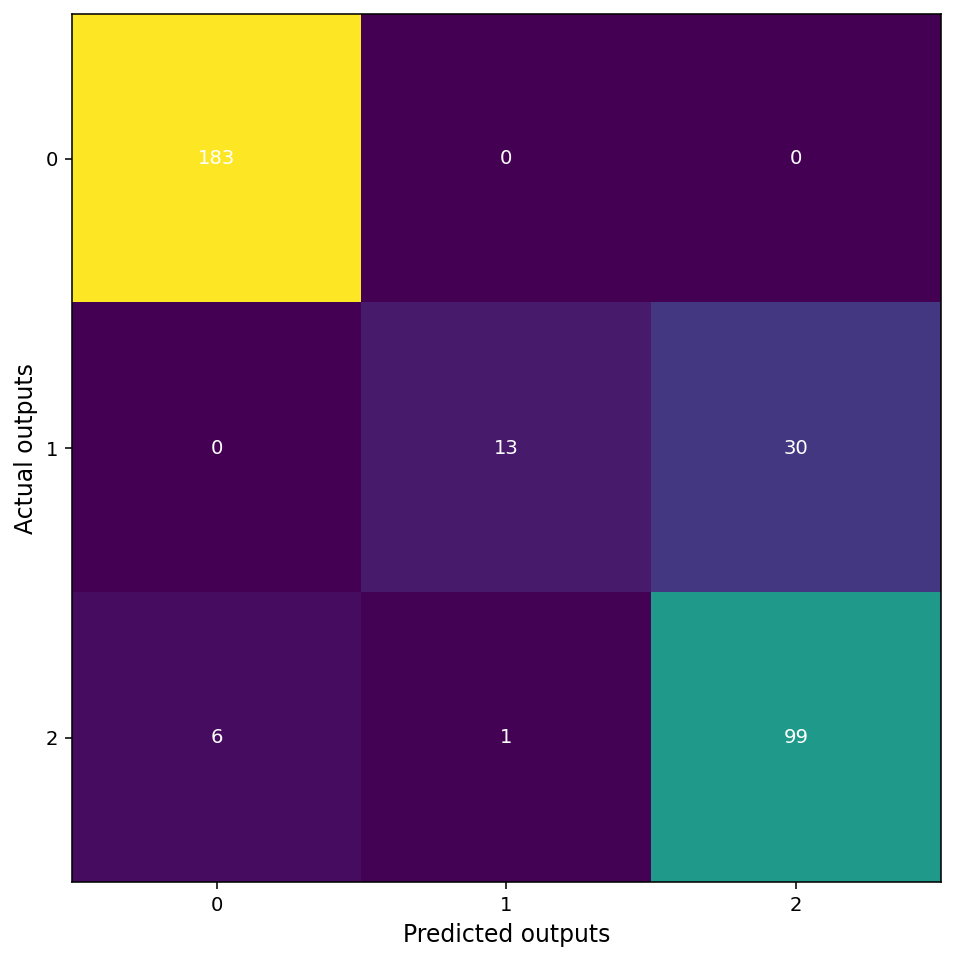

In [71]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(3))
ax.yaxis.set(ticks=range(3))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

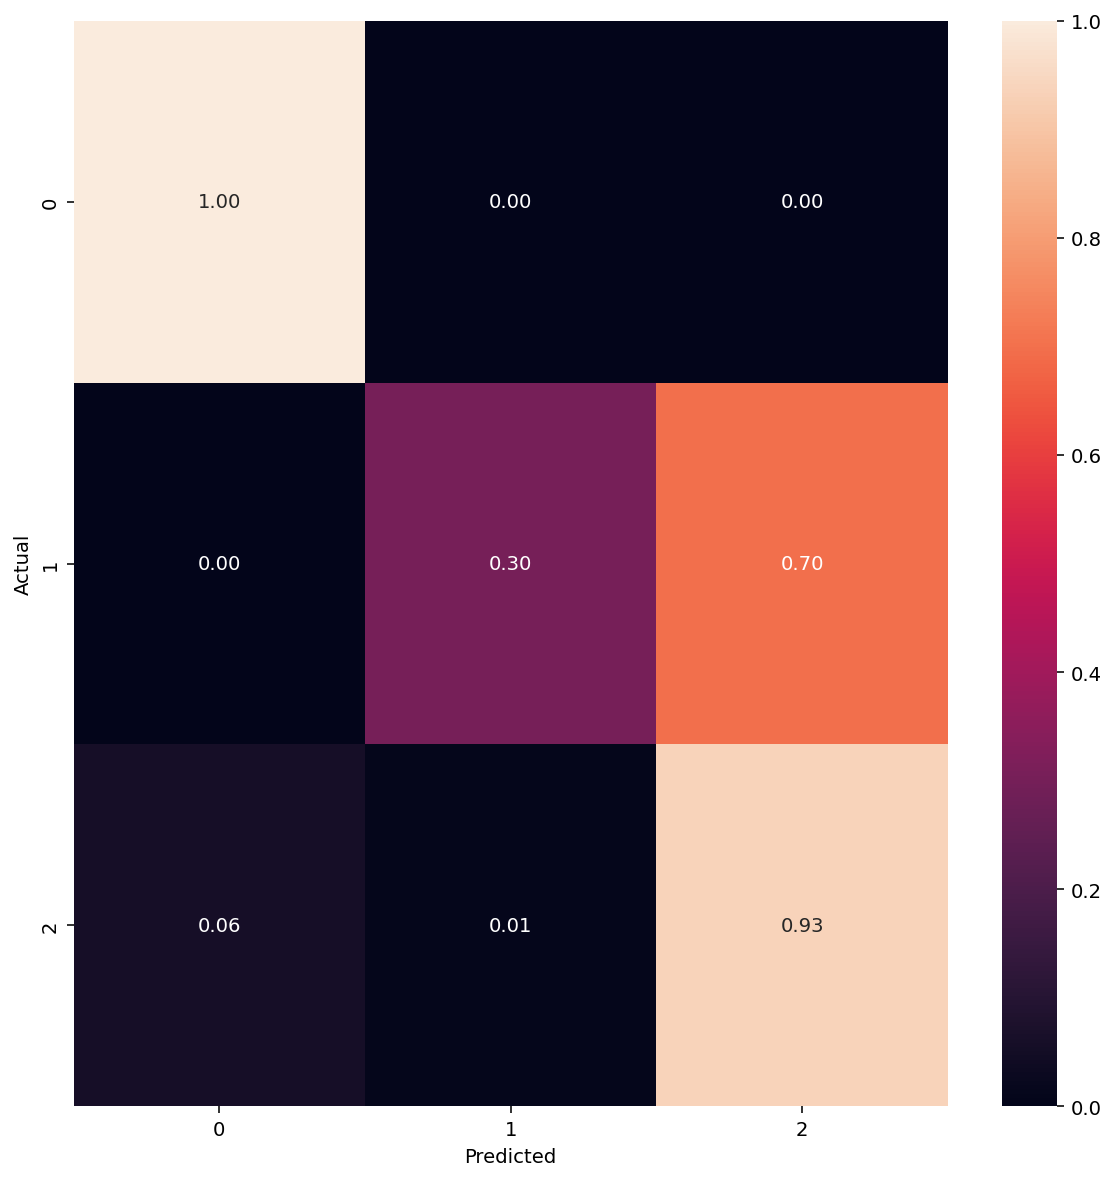

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# Feature Selection

## bSMOTE: Borderline-1

In [73]:
features = pd.read_csv('DTI_with_group.csv')
# remove unnecessary columns and confounding variables
features = features.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
features = features.dropna()

labels = np.array(features['Research Group'])
features = features.drop('Research Group', axis=1)

feature_list = list(features.columns)
features = np.array(features)

In [74]:
X_resampled, y_resampled = bSMOTE(kind='borderline-1').fit_resample(features, labels)
train_features, test_features, train_labels, test_labels = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=71)

In [75]:
# new model with only the most important structures
clf_most_important = RandomForestClassifier(n_estimators = 12000, random_state = 102)

important_indices = [feature_list.index('AD_CGH_L'), feature_list.index('RD_CGH_L'), feature_list.index('MD_CGH_L'),
                    feature_list.index('FA_CGH_L'), feature_list.index('AD_FX'), feature_list.index('RD_FX'),
                    feature_list.index('MD_FX'), feature_list.index('FA_FX'), feature_list.index('AD_CST_R'),
                    feature_list.index('RD_CST_R'), feature_list.index('MD_CST_R'), feature_list.index('FA_CST_R'),
                    feature_list.index('AD_SLF'), feature_list.index('RD_SLF'), feature_list.index('MD_SLF'),
                    feature_list.index('FA_SLF'), feature_list.index('AD_SLF_R'), feature_list.index('RD_SLF_R'),
                    feature_list.index('MD_SLF_R'), feature_list.index('FA_SLF_R'), feature_list.index('AD_TAP_R'),
                    feature_list.index('RD_TAP_R'), feature_list.index('MD_TAP_R'), feature_list.index('FA_TAP_R'),
                    feature_list.index('AD_TAP'), feature_list.index('RD_TAP'), feature_list.index('MD_TAP'),
                    feature_list.index('FA_TAP'), feature_list.index('AD_PCT'), feature_list.index('RD_PCT'), 
                    feature_list.index('MD_PCT'), feature_list.index('FA_PCT'), feature_list.index('AD_BCC'),
                    feature_list.index('RD_BCC'), feature_list.index('MD_BCC'), feature_list.index('FA_BCC'),
                    feature_list.index('AD_FXST'), feature_list.index('RD_FXST'), feature_list.index('MD_FXST'),
                    feature_list.index('FA_FXST'), feature_list.index('AD_SFO_L'), feature_list.index('RD_SFO_L'),
                    feature_list.index('MD_SFO_L'), feature_list.index('FA_SFO_L'), feature_list.index('AD_SFO_R'),
                    feature_list.index('RD_SFO_R'), feature_list.index('MD_SFO_R'), feature_list.index('FA_SFO_R'),
                    feature_list.index('AD_CR'), feature_list.index('RD_CR'), feature_list.index('MD_CR'),
                    feature_list.index('FA_CR'), feature_list.index('AD_SS_R'), feature_list.index('RD_SS_R'),
                    feature_list.index('MD_SS_R'), feature_list.index('FA_SS_R'), feature_list.index('AD_SS_L'),
                    feature_list.index('RD_SS_L'), feature_list.index('MD_SS_L'), feature_list.index('FA_SS_L')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

clf_most_important.fit(train_important, train_labels)
clf_most_important.score(test_important, test_labels)

0.9040632054176072

In [76]:
pred = clf_most_important.predict(test_important)

print("Confusion Matrix:")
print(confusion_matrix(test_labels, pred))

print("Classification Report")
print(classification_report(test_labels, pred))

Confusion Matrix:
[[147   1   0   0   1   0]
 [  3 102  16   2  17   8]
 [  0   5 135   0   7   0]
 [  0   1   0 147   2   0]
 [  3   6   2   0 135   3]
 [  2   4   0   0   2 135]]
Classification Report
              precision    recall  f1-score   support

          AD       0.95      0.99      0.97       149
          CN       0.86      0.69      0.76       148
        EMCI       0.88      0.92      0.90       147
        LMCI       0.99      0.98      0.98       150
         MCI       0.82      0.91      0.86       149
         SMC       0.92      0.94      0.93       143

    accuracy                           0.90       886
   macro avg       0.90      0.90      0.90       886
weighted avg       0.90      0.90      0.90       886



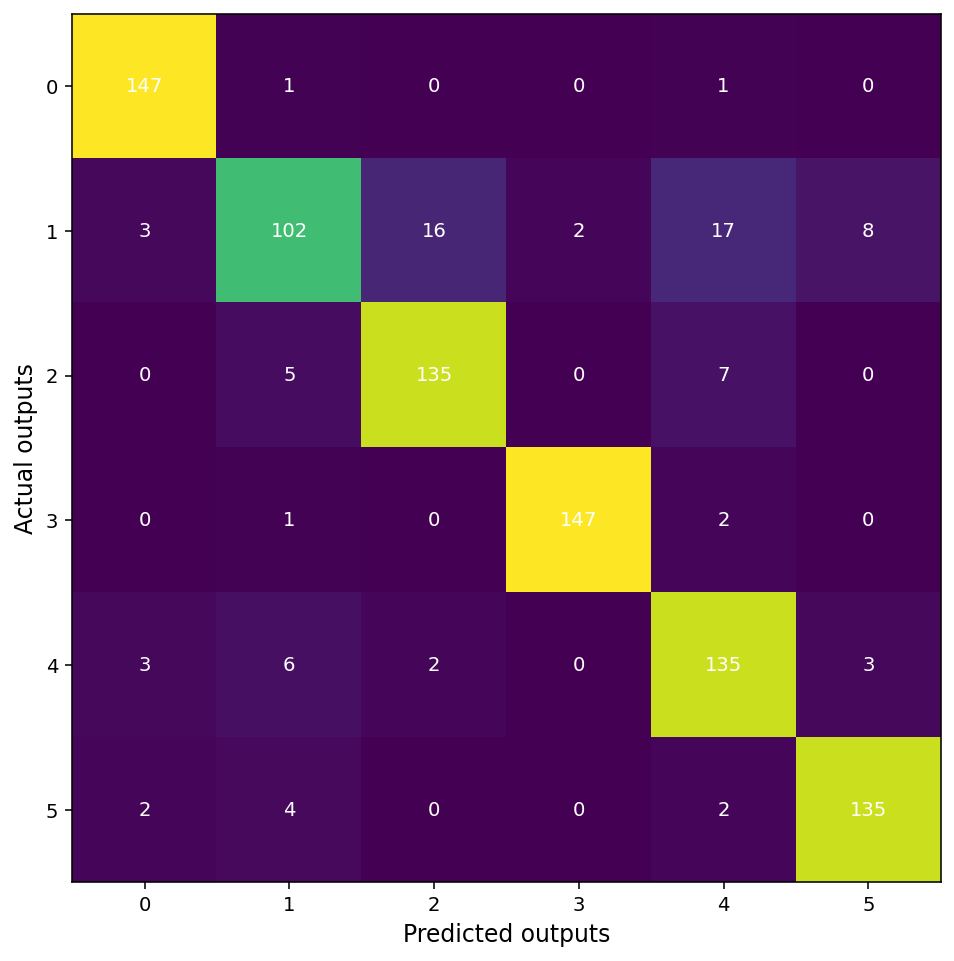

In [77]:
cm = confusion_matrix(test_labels, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(6))
ax.yaxis.set(ticks=range(6))
for i in range(6):
    for j in range(6):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

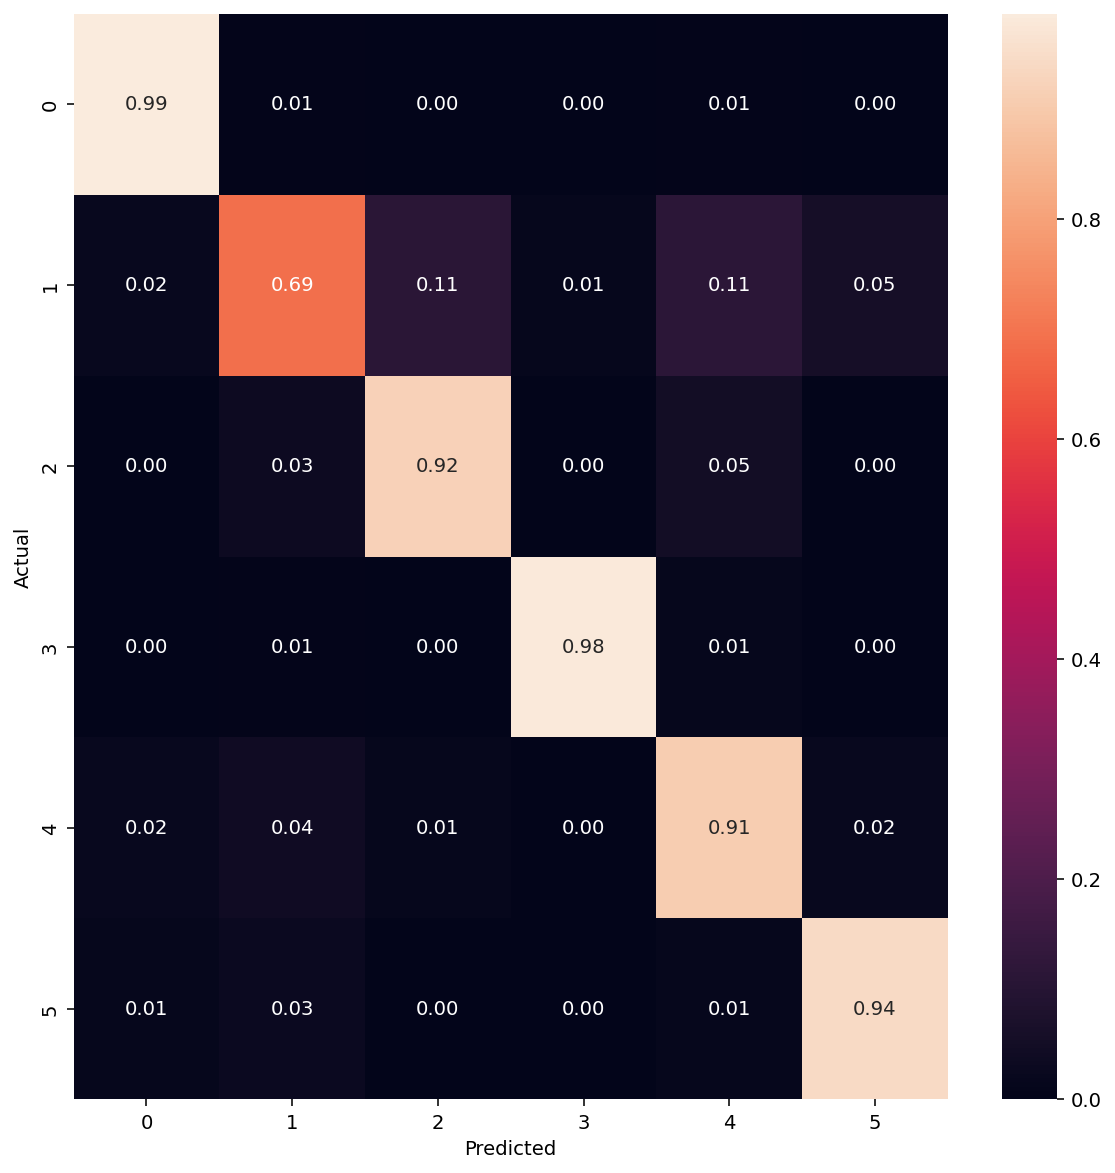

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### Combined MCI groups

In [79]:
features = pd.read_csv('DTI_with_group_comb.csv')
# remove unnecessary columns and confounding variables
features = features.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
features = features.dropna()

labels = np.array(features['Research Group'])
features = features.drop('Research Group', axis=1)

feature_list = list(features.columns)
features = np.array(features)

In [80]:
X_resampled, y_resampled = bSMOTE(kind='borderline-1').fit_resample(features, labels)
train_features, test_features, train_labels, test_labels = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=74)

In [81]:
# new model with only the most important structures
clf_most_important = RandomForestClassifier(n_estimators = 12000, random_state = 102)

important_indices = [feature_list.index('AD_CGH_L'), feature_list.index('RD_CGH_L'), feature_list.index('MD_CGH_L'),
                    feature_list.index('FA_CGH_L'), feature_list.index('AD_FX'), feature_list.index('RD_FX'),
                    feature_list.index('MD_FX'), feature_list.index('FA_FX'), feature_list.index('AD_CST_R'),
                    feature_list.index('RD_CST_R'), feature_list.index('MD_CST_R'), feature_list.index('FA_CST_R'),
                    feature_list.index('AD_SLF'), feature_list.index('RD_SLF'), feature_list.index('MD_SLF'),
                    feature_list.index('FA_SLF'), feature_list.index('AD_SLF_R'), feature_list.index('RD_SLF_R'),
                    feature_list.index('MD_SLF_R'), feature_list.index('FA_SLF_R'), feature_list.index('AD_TAP_R'),
                    feature_list.index('RD_TAP_R'), feature_list.index('MD_TAP_R'), feature_list.index('FA_TAP_R'),
                    feature_list.index('AD_TAP'), feature_list.index('RD_TAP'), feature_list.index('MD_TAP'),
                    feature_list.index('FA_TAP'), feature_list.index('AD_PCT'), feature_list.index('RD_PCT'), 
                    feature_list.index('MD_PCT'), feature_list.index('FA_PCT'), feature_list.index('AD_BCC'),
                    feature_list.index('RD_BCC'), feature_list.index('MD_BCC'), feature_list.index('FA_BCC'),
                    feature_list.index('AD_FXST'), feature_list.index('RD_FXST'), feature_list.index('MD_FXST'),
                    feature_list.index('FA_FXST'), feature_list.index('AD_SFO_L'), feature_list.index('RD_SFO_L'),
                    feature_list.index('MD_SFO_L'), feature_list.index('FA_SFO_L'), feature_list.index('AD_SFO_R'),
                    feature_list.index('RD_SFO_R'), feature_list.index('MD_SFO_R'), feature_list.index('FA_SFO_R'),
                    feature_list.index('AD_CR'), feature_list.index('RD_CR'), feature_list.index('MD_CR'),
                    feature_list.index('FA_CR'), feature_list.index('AD_SS_R'), feature_list.index('RD_SS_R'),
                    feature_list.index('MD_SS_R'), feature_list.index('FA_SS_R'), feature_list.index('AD_SS_L'),
                    feature_list.index('RD_SS_L'), feature_list.index('MD_SS_L'), feature_list.index('FA_SS_L')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

clf_most_important.fit(train_important, train_labels)
clf_most_important.score(test_important, test_labels)

0.7855711422845691

In [82]:
pred = clf_most_important.predict(test_important)

print("Confusion Matrix:")
print(confusion_matrix(test_labels, pred))

print("Classification Report")
print(classification_report(test_labels, pred))

Confusion Matrix:
[[156   6   3]
 [  3 120  34]
 [ 10  51 116]]
Classification Report
              precision    recall  f1-score   support

          AD       0.92      0.95      0.93       165
          CN       0.68      0.76      0.72       157
         MCI       0.76      0.66      0.70       177

    accuracy                           0.79       499
   macro avg       0.79      0.79      0.79       499
weighted avg       0.79      0.79      0.78       499



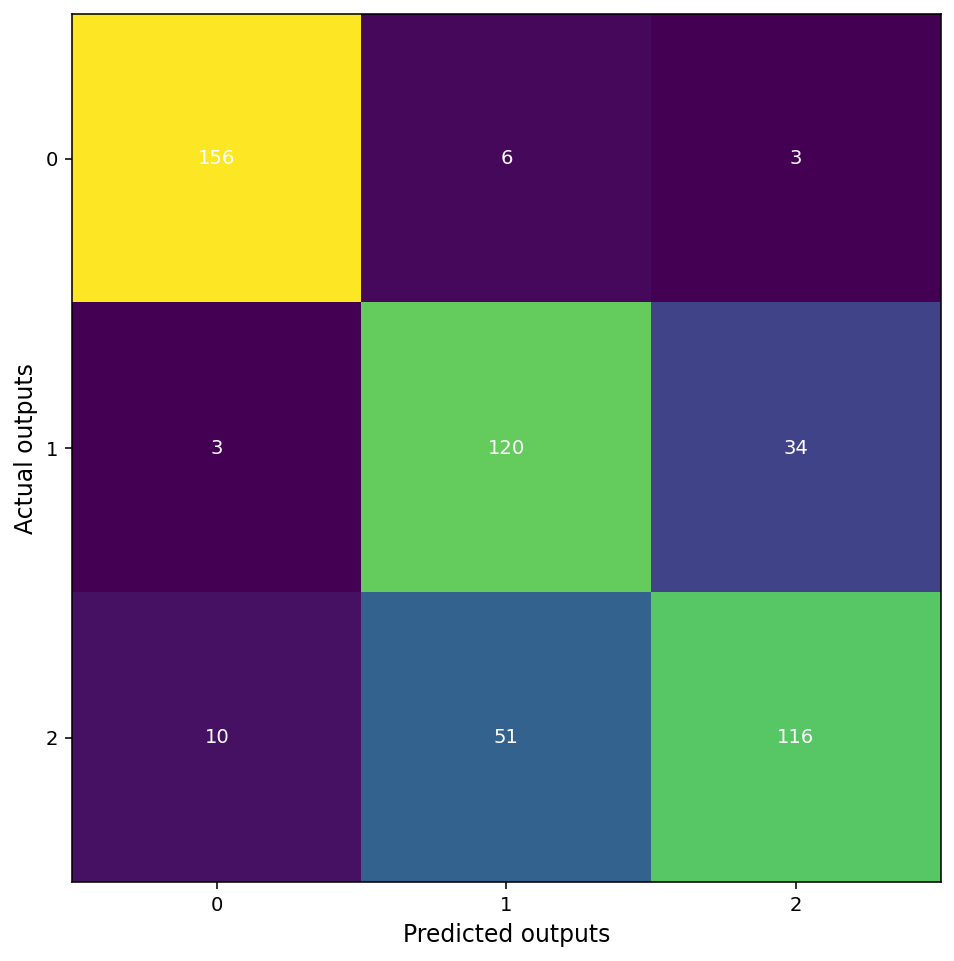

In [83]:
cm = confusion_matrix(test_labels, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(3))
ax.yaxis.set(ticks=range(3))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

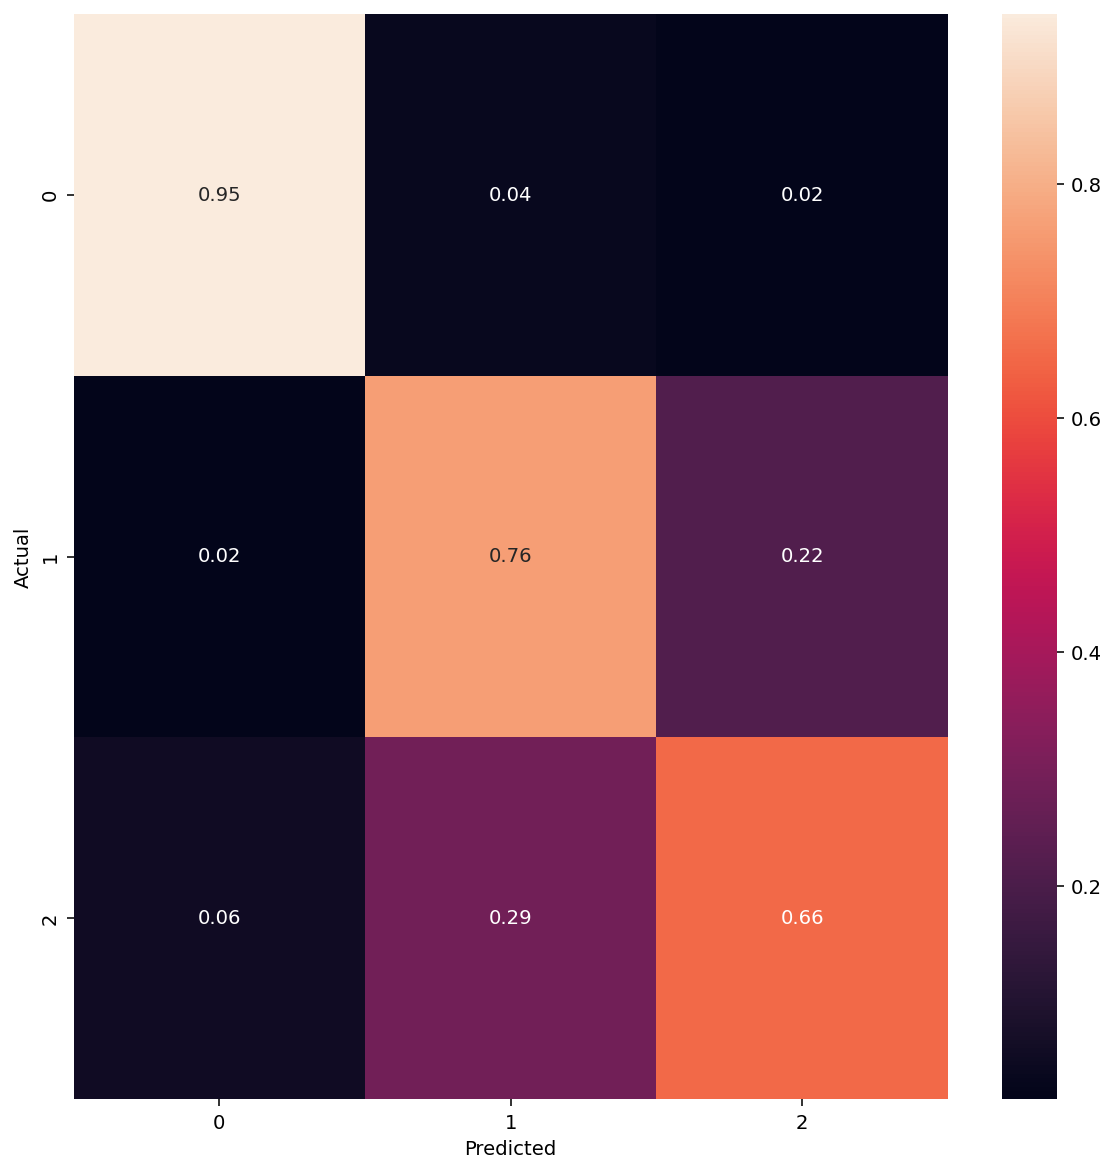

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## bSMOTE with SVM

In [85]:
features = pd.read_csv('DTI_with_group.csv')
# remove unnecessary columns and confounding variables
features = features.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
features = features.dropna()

labels = np.array(features['Research Group'])
features = features.drop('Research Group', axis=1)

feature_list = list(features.columns)
features = np.array(features)

In [86]:
X_resampled, y_resampled = SVMSMOTE().fit_resample(features, labels)
train_features, test_features, train_labels, test_labels = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=74)

In [87]:
# new model with only the most important structures
clf_most_important = RandomForestClassifier(n_estimators = 12000, random_state = 102)

important_indices = [feature_list.index('AD_CGH_L'), feature_list.index('RD_CGH_L'), feature_list.index('MD_CGH_L'),
                    feature_list.index('FA_CGH_L'), feature_list.index('AD_FX'), feature_list.index('RD_FX'),
                    feature_list.index('MD_FX'), feature_list.index('FA_FX'), feature_list.index('AD_CST_R'),
                    feature_list.index('RD_CST_R'), feature_list.index('MD_CST_R'), feature_list.index('FA_CST_R'),
                    feature_list.index('AD_SLF'), feature_list.index('RD_SLF'), feature_list.index('MD_SLF'),
                    feature_list.index('FA_SLF'), feature_list.index('AD_SLF_R'), feature_list.index('RD_SLF_R'),
                    feature_list.index('MD_SLF_R'), feature_list.index('FA_SLF_R'), feature_list.index('AD_TAP_R'),
                    feature_list.index('RD_TAP_R'), feature_list.index('MD_TAP_R'), feature_list.index('FA_TAP_R'),
                    feature_list.index('AD_TAP'), feature_list.index('RD_TAP'), feature_list.index('MD_TAP'),
                    feature_list.index('FA_TAP'), feature_list.index('AD_PCT'), feature_list.index('RD_PCT'), 
                    feature_list.index('MD_PCT'), feature_list.index('FA_PCT'), feature_list.index('AD_BCC'),
                    feature_list.index('RD_BCC'), feature_list.index('MD_BCC'), feature_list.index('FA_BCC'),
                    feature_list.index('AD_FXST'), feature_list.index('RD_FXST'), feature_list.index('MD_FXST'),
                    feature_list.index('FA_FXST'), feature_list.index('AD_SFO_L'), feature_list.index('RD_SFO_L'),
                    feature_list.index('MD_SFO_L'), feature_list.index('FA_SFO_L'), feature_list.index('AD_SFO_R'),
                    feature_list.index('RD_SFO_R'), feature_list.index('MD_SFO_R'), feature_list.index('FA_SFO_R'),
                    feature_list.index('AD_CR'), feature_list.index('RD_CR'), feature_list.index('MD_CR'),
                    feature_list.index('FA_CR'), feature_list.index('AD_SS_R'), feature_list.index('RD_SS_R'),
                    feature_list.index('MD_SS_R'), feature_list.index('FA_SS_R'), feature_list.index('AD_SS_L'),
                    feature_list.index('RD_SS_L'), feature_list.index('MD_SS_L'), feature_list.index('FA_SS_L')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

clf_most_important.fit(train_important, train_labels)
clf_most_important.score(test_important, test_labels)

0.8471337579617835

In [88]:
pred = clf_most_important.predict(test_important)

print("Confusion Matrix:")
print(confusion_matrix(test_labels, pred))

print("Classification Report")
print(classification_report(test_labels, pred))

Confusion Matrix:
[[ 68   2   2   0   1   0]
 [  3 110   7   1  14   5]
 [  3   9  68   0   0   0]
 [  0   8   3  72   1   0]
 [  2  26   3   0 122   3]
 [  1   2   0   0   0  92]]
Classification Report
              precision    recall  f1-score   support

          AD       0.88      0.93      0.91        73
          CN       0.70      0.79      0.74       140
        EMCI       0.82      0.85      0.83        80
        LMCI       0.99      0.86      0.92        84
         MCI       0.88      0.78      0.83       156
         SMC       0.92      0.97      0.94        95

    accuracy                           0.85       628
   macro avg       0.87      0.86      0.86       628
weighted avg       0.85      0.85      0.85       628



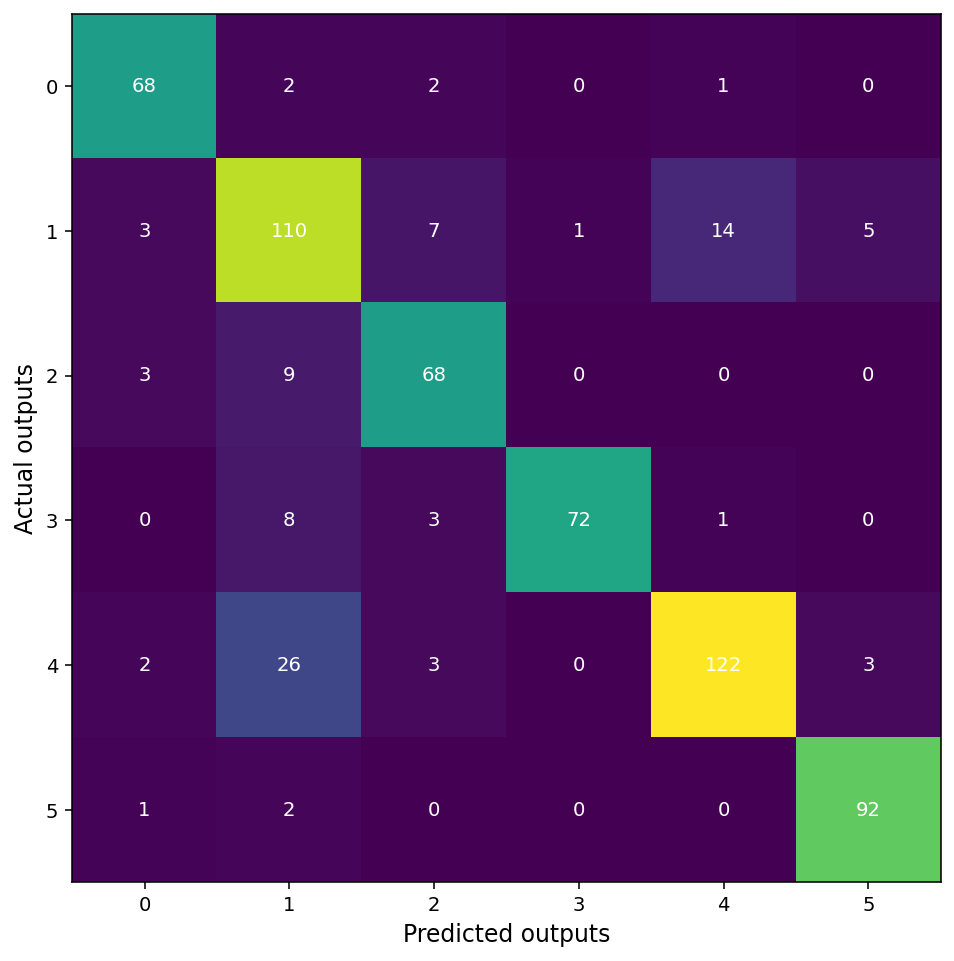

In [89]:
cm = confusion_matrix(test_labels, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(6))
ax.yaxis.set(ticks=range(6))
for i in range(6):
    for j in range(6):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

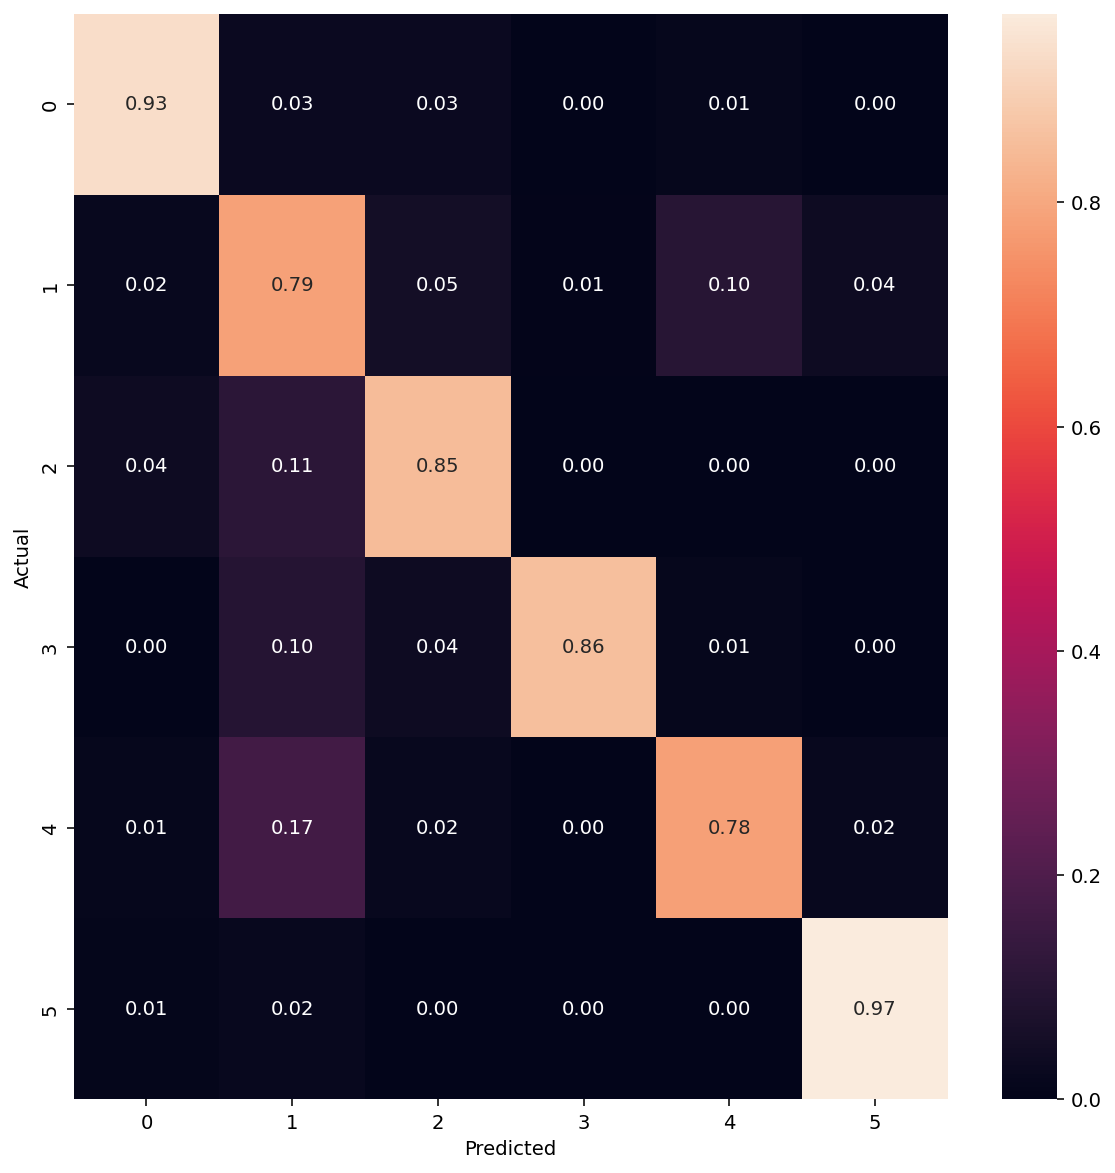

In [90]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### Combined MCI groups

In [91]:
features = pd.read_csv('DTI_with_group_comb.csv')
# remove unnecessary columns and confounding variables
features = features.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
features = features.dropna()

labels = np.array(features['Research Group'])
features = features.drop('Research Group', axis=1)

feature_list = list(features.columns)
features = np.array(features)

In [92]:
X_resampled, y_resampled = SVMSMOTE().fit_resample(features, labels)
train_features, test_features, train_labels, test_labels = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=77)

In [93]:
# new model with only the most important structures
clf_most_important = RandomForestClassifier(n_estimators = 12000, random_state = 107)

important_indices = [feature_list.index('AD_CGH_L'), feature_list.index('RD_CGH_L'), feature_list.index('MD_CGH_L'),
                    feature_list.index('FA_CGH_L'), feature_list.index('AD_FX'), feature_list.index('RD_FX'),
                    feature_list.index('MD_FX'), feature_list.index('FA_FX'), feature_list.index('AD_CST_R'),
                    feature_list.index('RD_CST_R'), feature_list.index('MD_CST_R'), feature_list.index('FA_CST_R'),
                    feature_list.index('AD_SLF'), feature_list.index('RD_SLF'), feature_list.index('MD_SLF'),
                    feature_list.index('FA_SLF'), feature_list.index('AD_SLF_R'), feature_list.index('RD_SLF_R'),
                    feature_list.index('MD_SLF_R'), feature_list.index('FA_SLF_R'), feature_list.index('AD_TAP_R'),
                    feature_list.index('RD_TAP_R'), feature_list.index('MD_TAP_R'), feature_list.index('FA_TAP_R'),
                    feature_list.index('AD_TAP'), feature_list.index('RD_TAP'), feature_list.index('MD_TAP'),
                    feature_list.index('FA_TAP'), feature_list.index('AD_PCT'), feature_list.index('RD_PCT'), 
                    feature_list.index('MD_PCT'), feature_list.index('FA_PCT'), feature_list.index('AD_BCC'),
                    feature_list.index('RD_BCC'), feature_list.index('MD_BCC'), feature_list.index('FA_BCC'),
                    feature_list.index('AD_FXST'), feature_list.index('RD_FXST'), feature_list.index('MD_FXST'),
                    feature_list.index('FA_FXST'), feature_list.index('AD_SFO_L'), feature_list.index('RD_SFO_L'),
                    feature_list.index('MD_SFO_L'), feature_list.index('FA_SFO_L'), feature_list.index('AD_SFO_R'),
                    feature_list.index('RD_SFO_R'), feature_list.index('MD_SFO_R'), feature_list.index('FA_SFO_R'),
                    feature_list.index('AD_CR'), feature_list.index('RD_CR'), feature_list.index('MD_CR'),
                    feature_list.index('FA_CR'), feature_list.index('AD_SS_R'), feature_list.index('RD_SS_R'),
                    feature_list.index('MD_SS_R'), feature_list.index('FA_SS_R'), feature_list.index('AD_SS_L'),
                    feature_list.index('RD_SS_L'), feature_list.index('MD_SS_L'), feature_list.index('FA_SS_L')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

clf_most_important.fit(train_important, train_labels)
clf_most_important.score(test_important, test_labels)

0.7719714964370546

In [94]:
pred = clf_most_important.predict(test_important)

print("Confusion Matrix:")
print(confusion_matrix(test_labels, pred))

print("Classification Report")
print(classification_report(test_labels, pred))

Confusion Matrix:
[[ 85   1   6]
 [  1 109  52]
 [  3  33 131]]
Classification Report
              precision    recall  f1-score   support

          AD       0.96      0.92      0.94        92
          CN       0.76      0.67      0.71       162
         MCI       0.69      0.78      0.74       167

    accuracy                           0.77       421
   macro avg       0.80      0.79      0.80       421
weighted avg       0.78      0.77      0.77       421



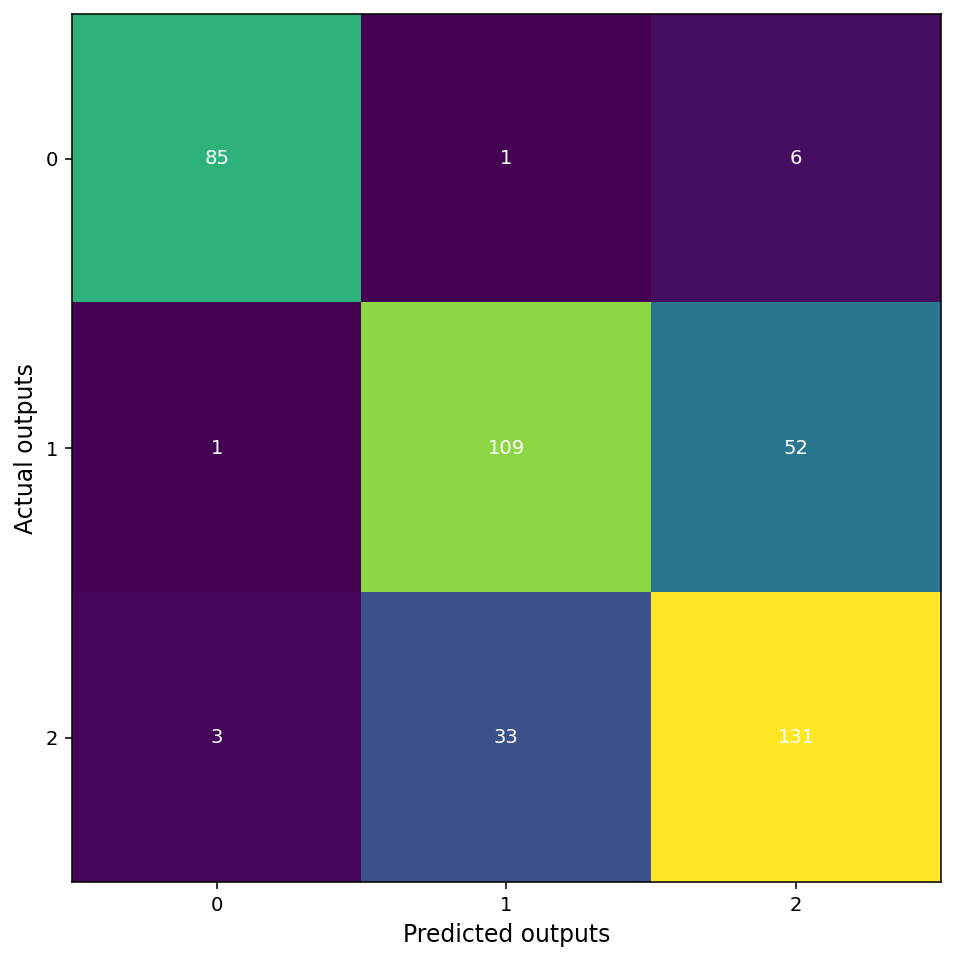

In [95]:
cm = confusion_matrix(test_labels, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(3))
ax.yaxis.set(ticks=range(3))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

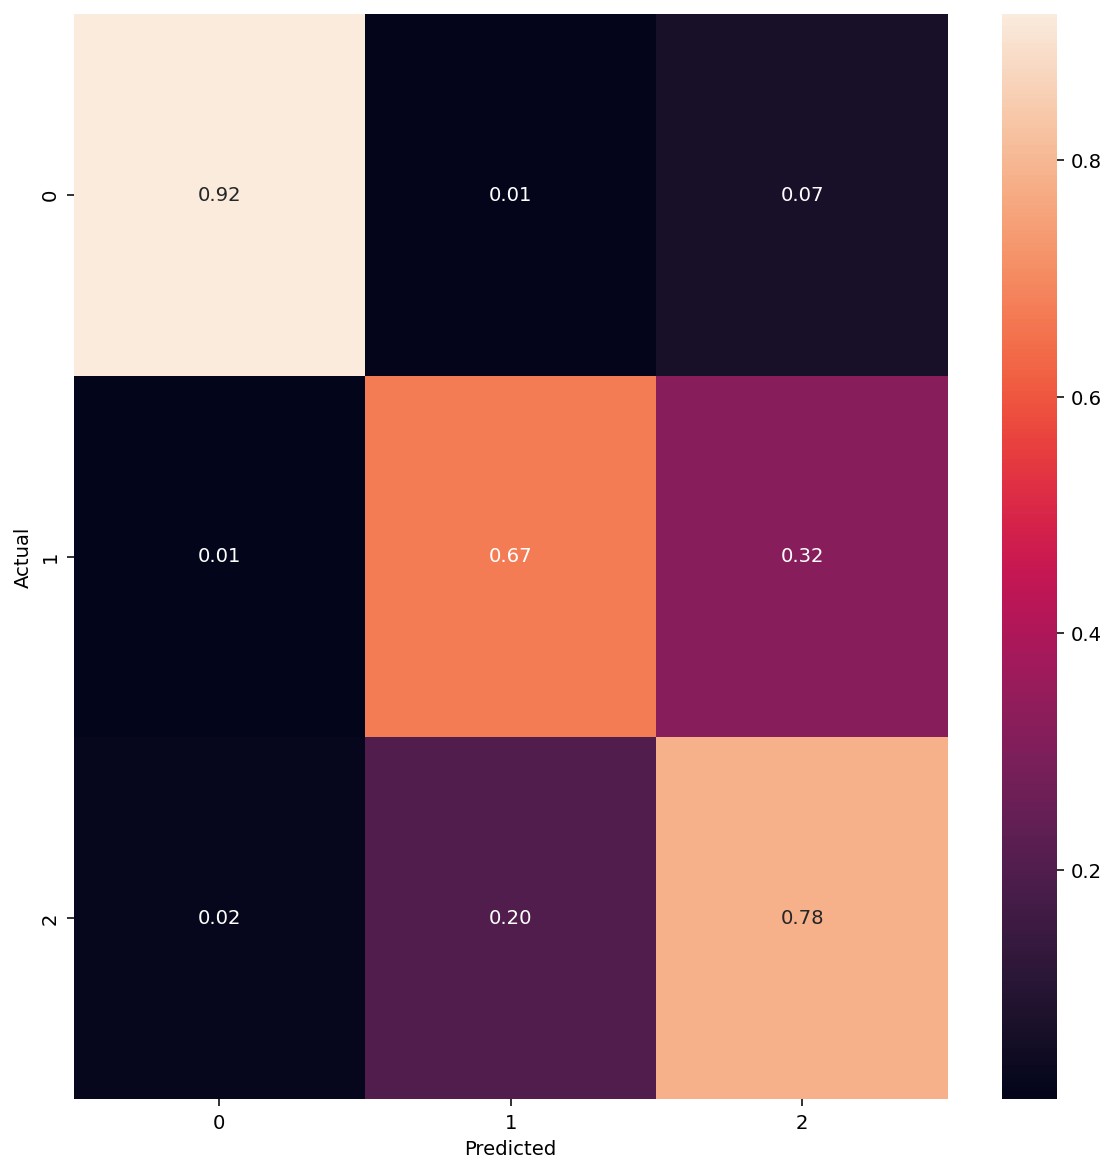

In [96]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## SMOTE + ENN

In [97]:
features = pd.read_csv('DTI_with_group.csv')
# remove unnecessary columns and confounding variables
features = features.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
features = features.dropna()

labels = np.array(features['Research Group'])
features = features.drop('Research Group', axis=1)

feature_list = list(features.columns)
features = np.array(features)

In [98]:
X_resampled, y_resampled = smote_enn.fit_resample(features, labels)
train_features, test_features, train_labels, test_labels = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=113)

In [99]:
# new model with only the most important structures
clf_most_important = RandomForestClassifier(n_estimators = 12000, random_state = 141)

important_indices = [feature_list.index('AD_CGH_L'), feature_list.index('RD_CGH_L'), feature_list.index('MD_CGH_L'),
                    feature_list.index('FA_CGH_L'), feature_list.index('AD_FX'), feature_list.index('RD_FX'),
                    feature_list.index('MD_FX'), feature_list.index('FA_FX'), feature_list.index('AD_CST_R'),
                    feature_list.index('RD_CST_R'), feature_list.index('MD_CST_R'), feature_list.index('FA_CST_R'),
                    feature_list.index('AD_SLF'), feature_list.index('RD_SLF'), feature_list.index('MD_SLF'),
                    feature_list.index('FA_SLF'), feature_list.index('AD_SLF_R'), feature_list.index('RD_SLF_R'),
                    feature_list.index('MD_SLF_R'), feature_list.index('FA_SLF_R'), feature_list.index('AD_TAP_R'),
                    feature_list.index('RD_TAP_R'), feature_list.index('MD_TAP_R'), feature_list.index('FA_TAP_R'),
                    feature_list.index('AD_TAP'), feature_list.index('RD_TAP'), feature_list.index('MD_TAP'),
                    feature_list.index('FA_TAP'), feature_list.index('AD_PCT'), feature_list.index('RD_PCT'), 
                    feature_list.index('MD_PCT'), feature_list.index('FA_PCT'), feature_list.index('AD_BCC'),
                    feature_list.index('RD_BCC'), feature_list.index('MD_BCC'), feature_list.index('FA_BCC'),
                    feature_list.index('AD_FXST'), feature_list.index('RD_FXST'), feature_list.index('MD_FXST'),
                    feature_list.index('FA_FXST'), feature_list.index('AD_SFO_L'), feature_list.index('RD_SFO_L'),
                    feature_list.index('MD_SFO_L'), feature_list.index('FA_SFO_L'), feature_list.index('AD_SFO_R'),
                    feature_list.index('RD_SFO_R'), feature_list.index('MD_SFO_R'), feature_list.index('FA_SFO_R'),
                    feature_list.index('AD_CR'), feature_list.index('RD_CR'), feature_list.index('MD_CR'),
                    feature_list.index('FA_CR'), feature_list.index('AD_SS_R'), feature_list.index('RD_SS_R'),
                    feature_list.index('MD_SS_R'), feature_list.index('FA_SS_R'), feature_list.index('AD_SS_L'),
                    feature_list.index('RD_SS_L'), feature_list.index('MD_SS_L'), feature_list.index('FA_SS_L')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

clf_most_important.fit(train_important, train_labels)
clf_most_important.score(test_important, test_labels)

0.9540389972144847

In [100]:
pred = clf_most_important.predict(test_important)

print("Confusion Matrix:")
print(confusion_matrix(test_labels, pred))

print("Classification Report")
print(classification_report(test_labels, pred))

Confusion Matrix:
[[150   0   1   0   4   2]
 [  1   0   1   2   0   0]
 [  1   0 132   0   4   1]
 [  0   0   3 123   0   0]
 [  1   0   7   2 140   3]
 [  0   0   0   0   0 140]]
Classification Report
              precision    recall  f1-score   support

          AD       0.98      0.96      0.97       157
          CN       0.00      0.00      0.00         4
        EMCI       0.92      0.96      0.94       138
        LMCI       0.97      0.98      0.97       126
         MCI       0.95      0.92      0.93       153
         SMC       0.96      1.00      0.98       140

    accuracy                           0.95       718
   macro avg       0.80      0.80      0.80       718
weighted avg       0.95      0.95      0.95       718



/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

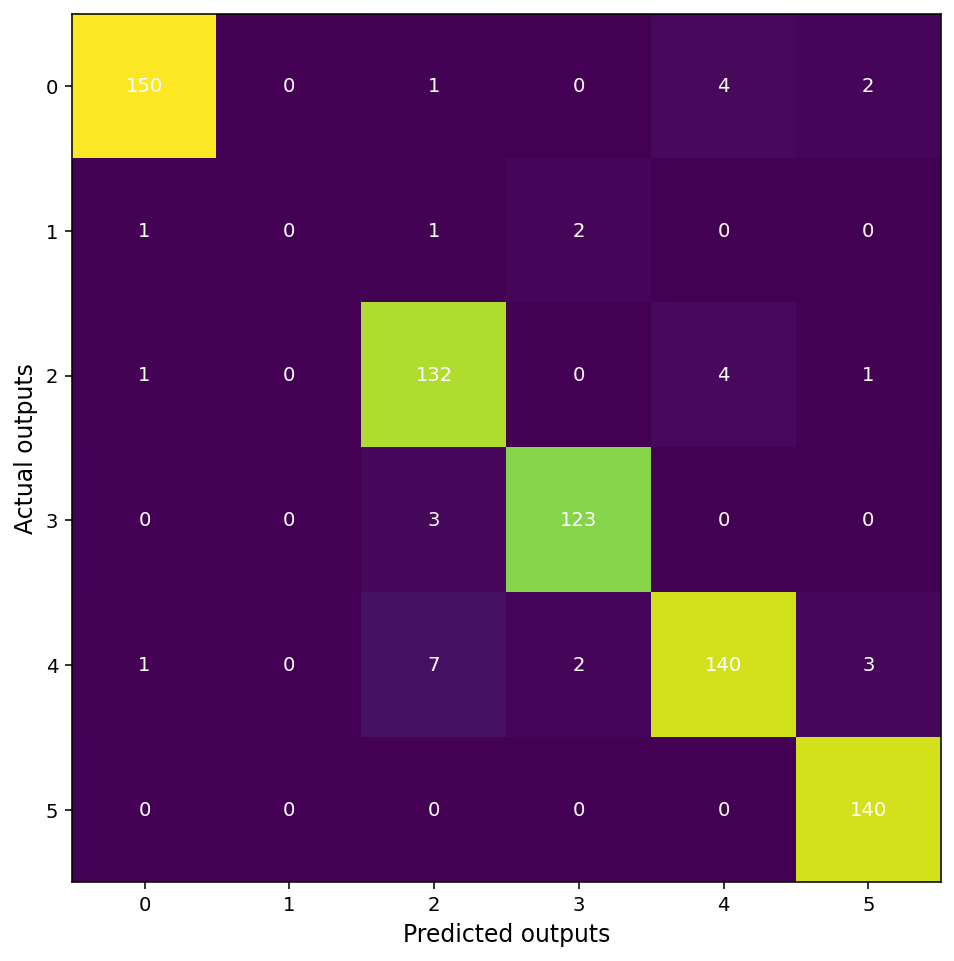

In [101]:
cm = confusion_matrix(test_labels, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(6))
ax.yaxis.set(ticks=range(6))
for i in range(6):
    for j in range(6):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

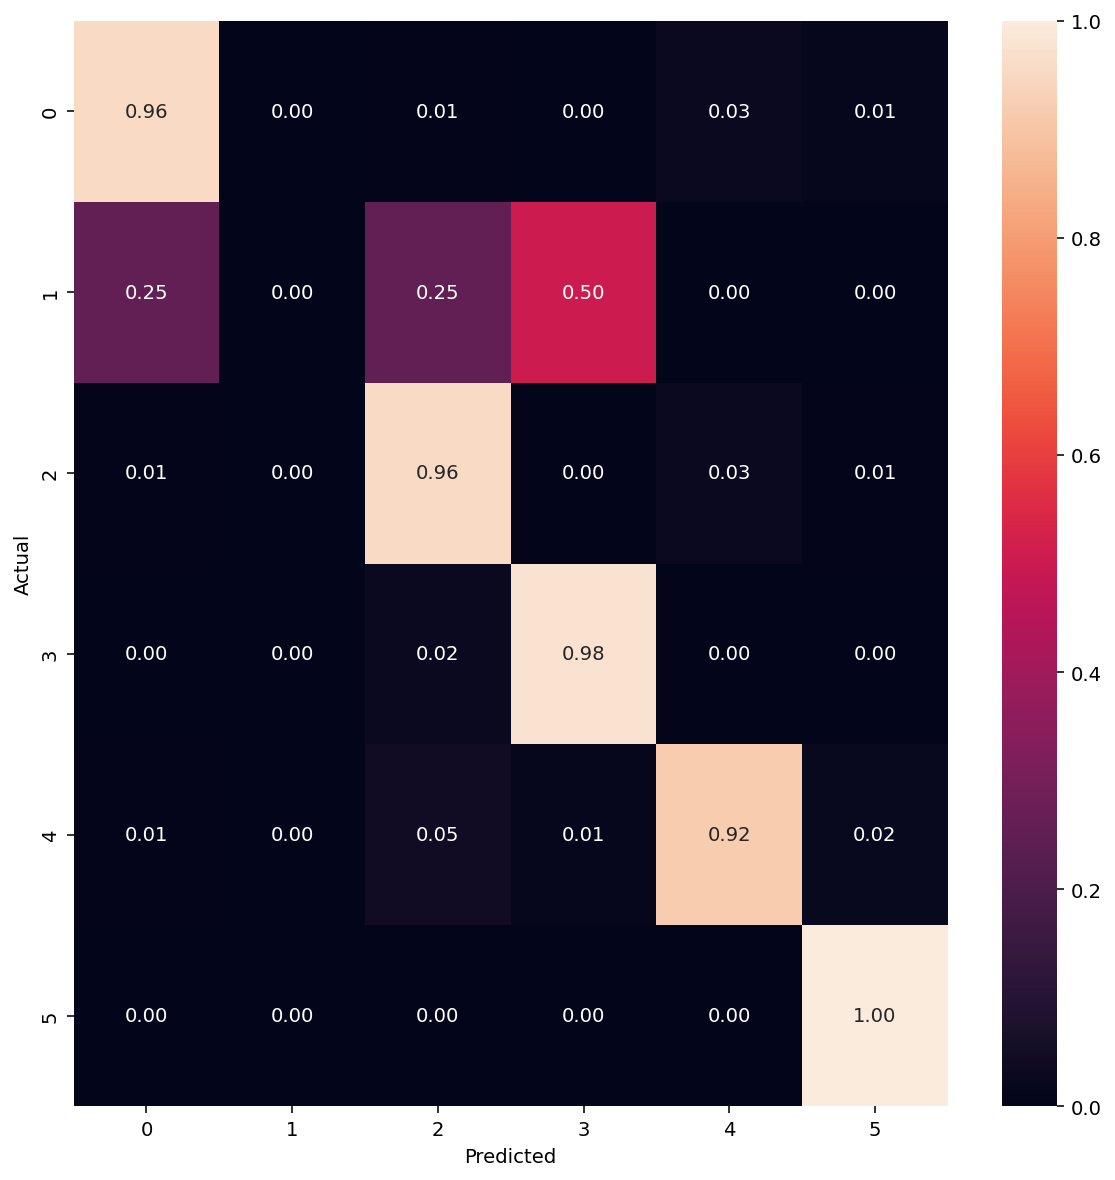

In [102]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### Combined MCI groups

In [103]:
features = pd.read_csv('DTI_with_group_comb.csv')
# remove unnecessary columns and confounding variables
features = features.drop(['IMAGEUID', 'COLPROT', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'VERSION', 
                                  'MANUFACTURER', 'RUNDATE', 'STATUS', 'QC', 'update_stamp', 'VOLUMES',
                                 'Sex', 'Age'], axis=1)

# remove rows with empty values
features = features.dropna()

labels = np.array(features['Research Group'])
features = features.drop('Research Group', axis=1)

feature_list = list(features.columns)
features = np.array(features)

In [104]:
X_resampled, y_resampled = smote_enn.fit_resample(features, labels)
train_features, test_features, train_labels, test_labels = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=113)

In [105]:
# new model with only the most important structures
clf_most_important = RandomForestClassifier(n_estimators = 12000, random_state = 141)

important_indices = [feature_list.index('AD_CGH_L'), feature_list.index('RD_CGH_L'), feature_list.index('MD_CGH_L'),
                    feature_list.index('FA_CGH_L'), feature_list.index('AD_FX'), feature_list.index('RD_FX'),
                    feature_list.index('MD_FX'), feature_list.index('FA_FX'), feature_list.index('AD_CST_R'),
                    feature_list.index('RD_CST_R'), feature_list.index('MD_CST_R'), feature_list.index('FA_CST_R'),
                    feature_list.index('AD_SLF'), feature_list.index('RD_SLF'), feature_list.index('MD_SLF'),
                    feature_list.index('FA_SLF'), feature_list.index('AD_SLF_R'), feature_list.index('RD_SLF_R'),
                    feature_list.index('MD_SLF_R'), feature_list.index('FA_SLF_R'), feature_list.index('AD_TAP_R'),
                    feature_list.index('RD_TAP_R'), feature_list.index('MD_TAP_R'), feature_list.index('FA_TAP_R'),
                    feature_list.index('AD_TAP'), feature_list.index('RD_TAP'), feature_list.index('MD_TAP'),
                    feature_list.index('FA_TAP'), feature_list.index('AD_PCT'), feature_list.index('RD_PCT'), 
                    feature_list.index('MD_PCT'), feature_list.index('FA_PCT'), feature_list.index('AD_BCC'),
                    feature_list.index('RD_BCC'), feature_list.index('MD_BCC'), feature_list.index('FA_BCC'),
                    feature_list.index('AD_FXST'), feature_list.index('RD_FXST'), feature_list.index('MD_FXST'),
                    feature_list.index('FA_FXST'), feature_list.index('AD_SFO_L'), feature_list.index('RD_SFO_L'),
                    feature_list.index('MD_SFO_L'), feature_list.index('FA_SFO_L'), feature_list.index('AD_SFO_R'),
                    feature_list.index('RD_SFO_R'), feature_list.index('MD_SFO_R'), feature_list.index('FA_SFO_R'),
                    feature_list.index('AD_CR'), feature_list.index('RD_CR'), feature_list.index('MD_CR'),
                    feature_list.index('FA_CR'), feature_list.index('AD_SS_R'), feature_list.index('RD_SS_R'),
                    feature_list.index('MD_SS_R'), feature_list.index('FA_SS_R'), feature_list.index('AD_SS_L'),
                    feature_list.index('RD_SS_L'), feature_list.index('MD_SS_L'), feature_list.index('FA_SS_L')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

clf_most_important.fit(train_important, train_labels)
clf_most_important.score(test_important, test_labels)

0.8807947019867549

In [106]:
pred = clf_most_important.predict(test_important)

print("Confusion Matrix:")
print(confusion_matrix(test_labels, pred))

print("Classification Report")
print(classification_report(test_labels, pred))

Confusion Matrix:
[[167   0   0]
 [  0  12  25]
 [  8   3  87]]
Classification Report
              precision    recall  f1-score   support

          AD       0.95      1.00      0.98       167
          CN       0.80      0.32      0.46        37
         MCI       0.78      0.89      0.83        98

    accuracy                           0.88       302
   macro avg       0.84      0.74      0.76       302
weighted avg       0.88      0.88      0.87       302



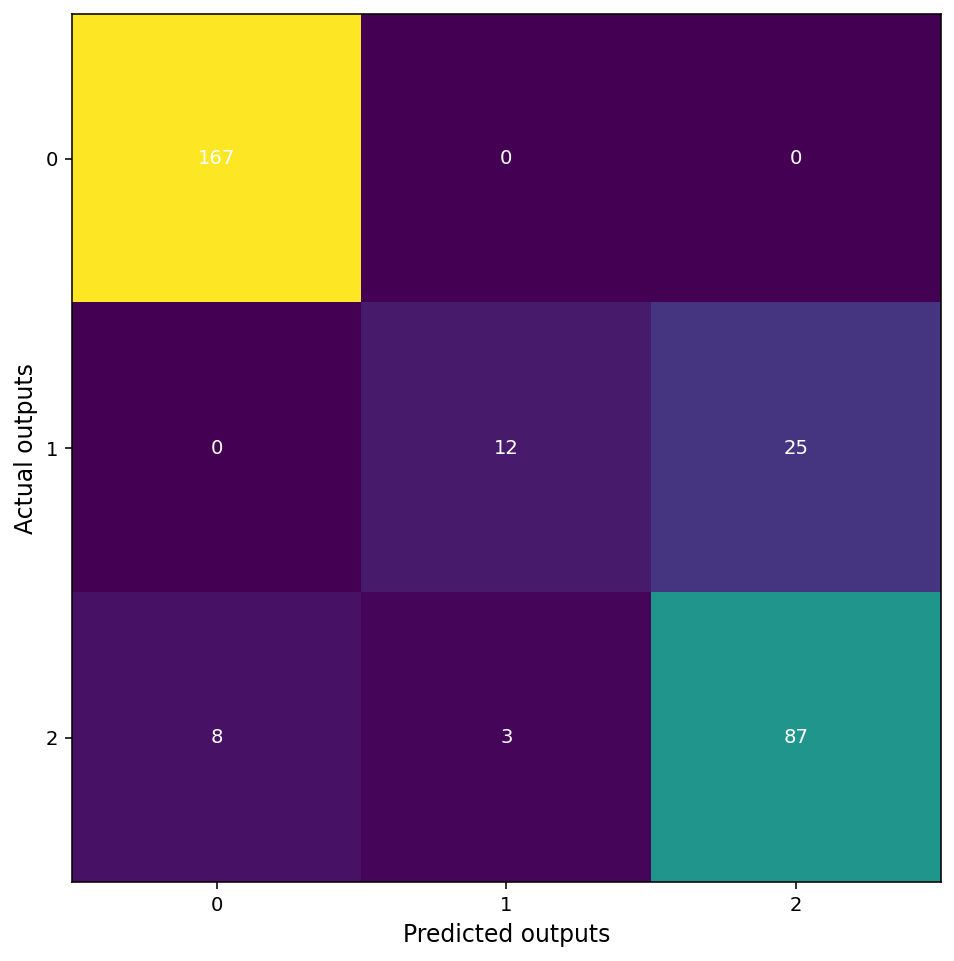

In [107]:
cm = confusion_matrix(test_labels, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(3))
ax.yaxis.set(ticks=range(3))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

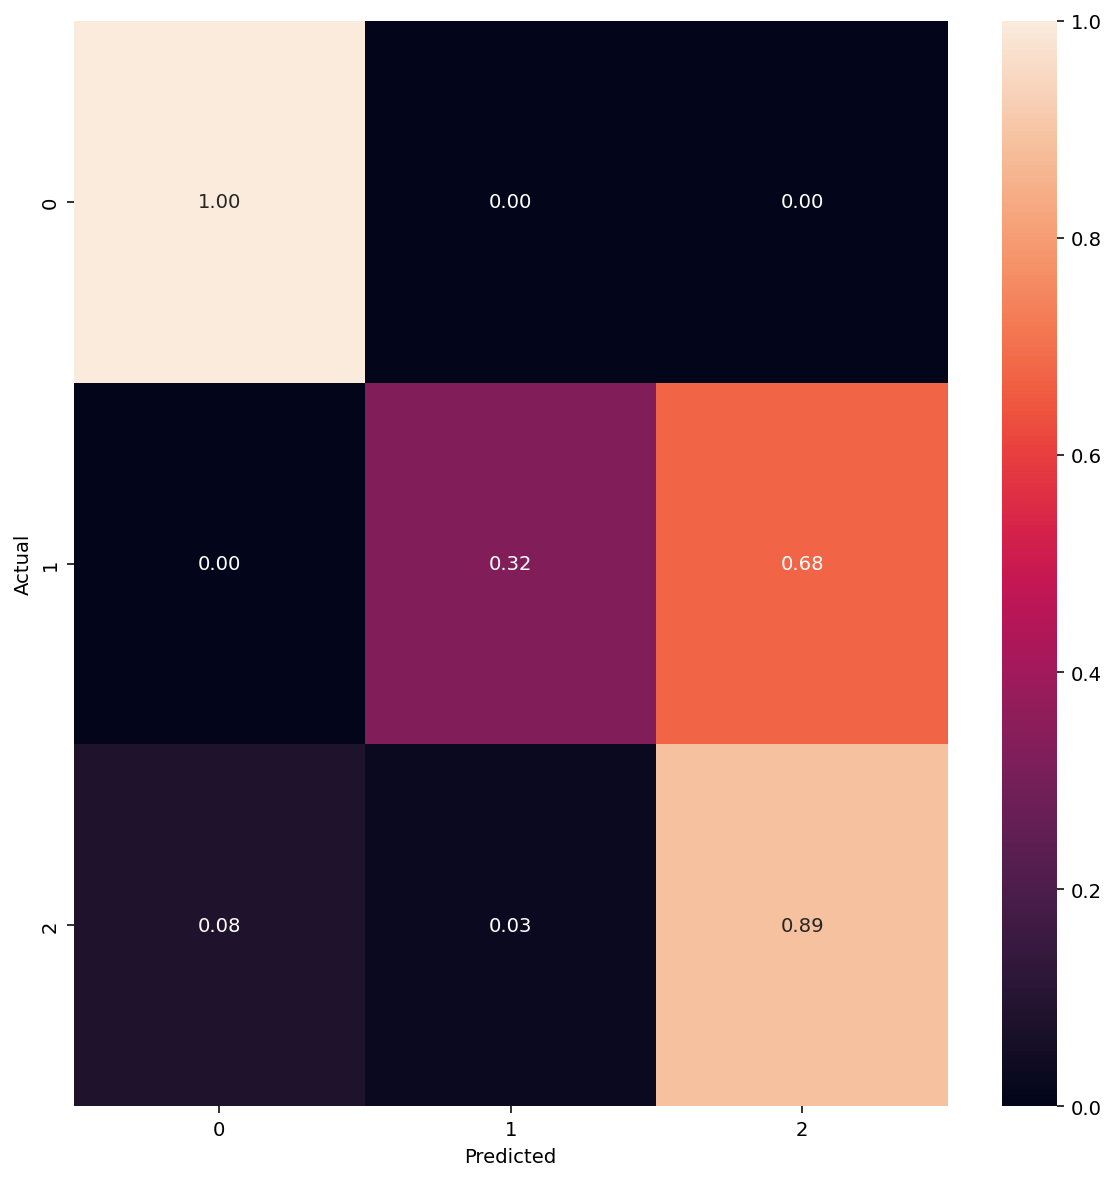

In [108]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)